## Service Centric Modelling and Prediction

In [1]:
import os
import pandas as pd
import torch
from darts import TimeSeries
from darts.models import NHiTSModel
from darts.utils.likelihood_models import GaussianLikelihood
from sklearn.preprocessing import MinMaxScaler
from darts.dataprocessing.transformers import Scaler
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl

import warnings

warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


# Define the columns to include in the new DataFrame
order_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'Order Management CPU Usage',
    'Order Management Memory Usage',
    'Order Management Request Count',
    'Order Management 5xx Failures',
    'Order Management Pod Count'
]
product_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'Product Catalog CPU Usage',
    'Product Catalog Memory Usage',
    'Product Catalog Request Count',
    'Product Catalog 5xx Failures',
    'Product Catalog Pod Count'
]
shipping_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'Shipping Logistics CPU Usage',
    'Shipping Logistics Memory Usage',
    'Shipping Logistics Request Count',
    'Shipping Logistics 5xx Failures',
    'Shipping Logistics Pod Count'
]
user_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'User Account CPU Usage',
    'User Account Memory Usage',
    'User Account Request Count',
    'User Account 5xx Failures',
    'User Account Pod Count'
]
reviews_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'Review Rating CPU Usage',
    'Review Rating Memory Usage',
    'Review Rating Request Count',
    'Review Rating 5xx Failures',
    'Review Rating Pod Count'
]
payment_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'Payment Processing CPU Usage',
    'Payment Processing Memory Usage',
    'Payment Processing Request Count',
    'Payment Processing 5xx Failures',
    'Payment Processing Pod Count'
]

file_path = '~/Downloads/Collected Data - 15 Oct 23:59:00.csv'

# Creating dataframes for each service
order_df = pd.read_csv(file_path, usecols=order_columns_to_include)
product_df = pd.read_csv(file_path, usecols=product_columns_to_include)
user_df = pd.read_csv(file_path, usecols=user_columns_to_include)
reviews_df = pd.read_csv(file_path, usecols=reviews_columns_to_include)
shipping_df = pd.read_csv(file_path, usecols=shipping_columns_to_include)
payment_df = pd.read_csv(file_path, usecols=payment_columns_to_include)

order_df.fillna(0, inplace=True)
product_df.fillna(0, inplace=True)
user_df.fillna(0, inplace=True)
reviews_df.fillna(0, inplace=True)
shipping_df.fillna(0, inplace=True)
payment_df.fillna(0, inplace=True)


# Convert 'Timestamp [ms]' to datetime and set it as the index
order_df['Time'] = pd.to_datetime(order_df['Time'])
order_df.set_index('Time', inplace=True)
order_df['Time'] = order_df.index
order_df.head()

product_df['Time'] = pd.to_datetime(product_df['Time'])
product_df.set_index('Time', inplace=True)
product_df['Time'] = product_df.index
product_df.head()

user_df['Time'] = pd.to_datetime(user_df['Time'])
user_df.set_index('Time', inplace=True)
user_df['Time'] = user_df.index
user_df.head()

reviews_df['Time'] = pd.to_datetime(reviews_df['Time'])
reviews_df.set_index('Time', inplace=True)
reviews_df['Time'] = reviews_df.index
reviews_df.head()

shipping_df['Time'] = pd.to_datetime(shipping_df['Time'])
shipping_df.set_index('Time', inplace=True)
shipping_df['Time'] = shipping_df.index
shipping_df.head()

payment_df['Time'] = pd.to_datetime(payment_df['Time'])
payment_df.set_index('Time', inplace=True)
payment_df['Time'] = payment_df.index
payment_df.head()

order_df.head()

Cluster CPU  Cluster Memory  Order Management CPU Usage  \
Time                                                                           
2024-08-21 00:00:00         18.7            26.8                        83.7   
2024-08-21 00:01:00         19.8            27.0                        95.4   
2024-08-21 00:02:00         20.8            27.0                        87.5   
2024-08-21 00:03:00         20.7            27.0                        86.5   
2024-08-21 00:04:00         20.3            27.0                        83.8   

                     Order Management Memory Usage  \
Time                                                 
2024-08-21 00:00:00                           51.7   
2024-08-21 00:01:00                           51.6   
2024-08-21 00:02:00                           51.7   
2024-08-21 00:03:00                           51.8   
2024-08-21 00:04:00                           51.7   

                     Order Management Pod Count  \
Time                                              
2024-08-21 00:00:00                           4   
2024-08-21 00:01:00                           4   
2024-08-21 00:02:00                           4   
2024-08-21 00:03:00                           4   
2024-08-21 00:04:00                           4   

                     Order Management Request Count  \
Time                                                  
2024-08-21 00:00:00                          7320.0   
2024-08-21 00:01:00                          8318.0   
2024-08-21 00:02:00                          8660.0   
2024-08-21 00:03:00                          7706.0   
2024-08-21 00:04:00                          7354.0   

                     Order Management 5xx Failures                Time  
Time                                                                    
2024-08-21 00:00:00                            0.0 2024-08-21 00:00:00  
2024-08-21 00:01:00                            2.0 2024-08-21 00:01:00  
2024-08-21 00:02:00                            0.0 2024-08-21 00:02:00  
2024-08-21 00:03:00                            0.0 2024-08-21 00:03:00  
2024-08-21 00:04:00                            0.0 2024-08-21 00:04:00

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Function to apply triple exponential smoothing on each column
def apply_triple_exponential_smoothing(df, seasonal_periods, trend_type='add', seasonal_type='add'):
    smoothed_df = pd.DataFrame(index=df.index)
    
    for column in df.columns:
        if column != 'Time':  # Avoid applying smoothing to the 'Time' column
            model = ExponentialSmoothing(df[column],
                                         trend=trend_type,
                                         seasonal=seasonal_type,
                                         seasonal_periods=seasonal_periods)
            smoothed_series = model.fit(smoothing_level=0.4, smoothing_trend=0.001, smoothing_seasonal=0.001).fittedvalues
            smoothed_df[column] = smoothed_series
            
    return smoothed_df

def plot_original_vs_smoothed(df, smoothed_df, title):
    plt.figure(figsize=(25, 40))
    columns = df.columns[:-1]  # Exclude 'Time' column
    
    for i, column in enumerate(columns, start=1):
        plt.subplot(7, 1, i)  # Adjust the subplot grid if necessary
        plt.plot(df.index, df[column], label='Original', color='blue')  # Use df.index for Time
        plt.plot(smoothed_df.index, smoothed_df[column], label='Smoothed', color='red')  # Use smoothed_df.index
        plt.title(f"{title} - {column}")
        plt.legend()

    plt.tight_layout()
    plt.savefig(f"{title} - Denoising")
    plt.show()

seasonal_periods = 24

# Apply smoothing and visualize for each service
order_smoothed = apply_triple_exponential_smoothing(order_df, seasonal_periods)
plot_original_vs_smoothed(order_df, order_smoothed, 'Order Management')

product_smoothed = apply_triple_exponential_smoothing(product_df, seasonal_periods)
plot_original_vs_smoothed(product_df, product_smoothed, 'Product Catalog')

user_smoothed = apply_triple_exponential_smoothing(user_df, seasonal_periods)
plot_original_vs_smoothed(user_df, user_smoothed, 'User Account')

reviews_smoothed = apply_triple_exponential_smoothing(reviews_df, seasonal_periods)
plot_original_vs_smoothed(reviews_df, reviews_smoothed, 'Review Rating')

shipping_smoothed = apply_triple_exponential_smoothing(shipping_df, seasonal_periods)
plot_original_vs_smoothed(shipping_df, shipping_smoothed, 'Shipping Logistics')

payment_smoothed = apply_triple_exponential_smoothing(payment_df, seasonal_periods)
plot_original_vs_smoothed(payment_df, payment_smoothed, 'Payment Processing')

order_smoothed['Time'] = order_smoothed.index
product_smoothed['Time'] = product_smoothed.index
user_smoothed['Time'] = user_smoothed.index
reviews_smoothed['Time'] = reviews_smoothed.index
shipping_smoothed['Time'] = shipping_smoothed.index
payment_smoothed['Time'] = payment_smoothed.index

KeyboardInterrupt: 

In [30]:
user_smoothed.head()

Cluster CPU  Cluster Memory  User Account CPU Usage  \
Time                                                                       
2024-08-21 00:00:00    19.555571       26.852488               62.975311   
2024-08-21 00:01:00    19.249346       26.920113               62.333270   
2024-08-21 00:02:00    19.568787       26.974837               63.739073   
2024-08-21 00:03:00    20.158084       27.010360               62.082134   
2024-08-21 00:04:00    20.513061       27.092282               66.140061   

                     User Account Memory Usage  User Account Pod Count  \
Time                                                                     
2024-08-21 00:00:00                  28.642958                6.888733   
2024-08-21 00:01:00                  28.517591                6.967033   
2024-08-21 00:02:00                  28.564209                7.003546   
2024-08-21 00:03:00                  28.549001                7.020875   
2024-08-21 00:04:00                  28.355250                7.025681   

                     User Account Request Count  User Account 5xx Failures  \
Time                                                                         
2024-08-21 00:00:00                 3165.586470                  -0.655050   
2024-08-21 00:01:00                 3137.732774                   0.512811   
2024-08-21 00:02:00                 3209.556398                  -0.248700   
2024-08-21 00:03:00                 3327.012171                   0.682449   
2024-08-21 00:04:00                 3201.878537                   0.500071   

                                   Time  
Time                                     
2024-08-21 00:00:00 2024-08-21 00:00:00  
2024-08-21 00:01:00 2024-08-21 00:01:00  
2024-08-21 00:02:00 2024-08-21 00:02:00  
2024-08-21 00:03:00 2024-08-21 00:03:00  
2024-08-21 00:04:00 2024-08-21 00:04:00

In [31]:

# Define model arguments as a dictionary (JSON-like structure)
nhits_model_args = {
    "input_chunk_length": 1440,  # Past 24 hours time steps as input
    "output_chunk_length": 480,  # Predict the next 8 hours time steps
    "n_epochs": 40,              # Number of training epochs
    "num_stacks": 10,
    "num_layers": 6,
    "random_state": 42,           # For reproducibility
    "likelihood": GaussianLikelihood(),  # Likelihood model for probabilistic forecasts
    "batch_size": 128,
    "lr_scheduler_cls": torch.optim.lr_scheduler.ExponentialLR,
    "lr_scheduler_kwargs": {"gamma": 0.999},
    "save_checkpoints": True,
    "force_reset": True,
    "dropout": 0.2,
    "optimizer_kwargs": {"lr": 1e-3}  # Define your learning rate here
}

# Define early stopping arguments
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 3,
    "mode": "min",
    "strict": True,
    "verbose": True,
}

# Set the log directory where logs will be saved
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)

# Create a TensorBoardLogger
logger = TensorBoardLogger(log_dir, name="microservices_all_models")

# Define your trainer arguments
pl_trainer_kwargs = {
    "max_epochs": 40,
    "logger": logger,
    "callbacks": [
        EarlyStopping(**early_stopping_args)
    ]
}

# Directory where models will be saved
model_dir = os.path.expanduser("~/Documents/models/")
os.makedirs(model_dir, exist_ok=True)  # Create the directory if it doesn't exist


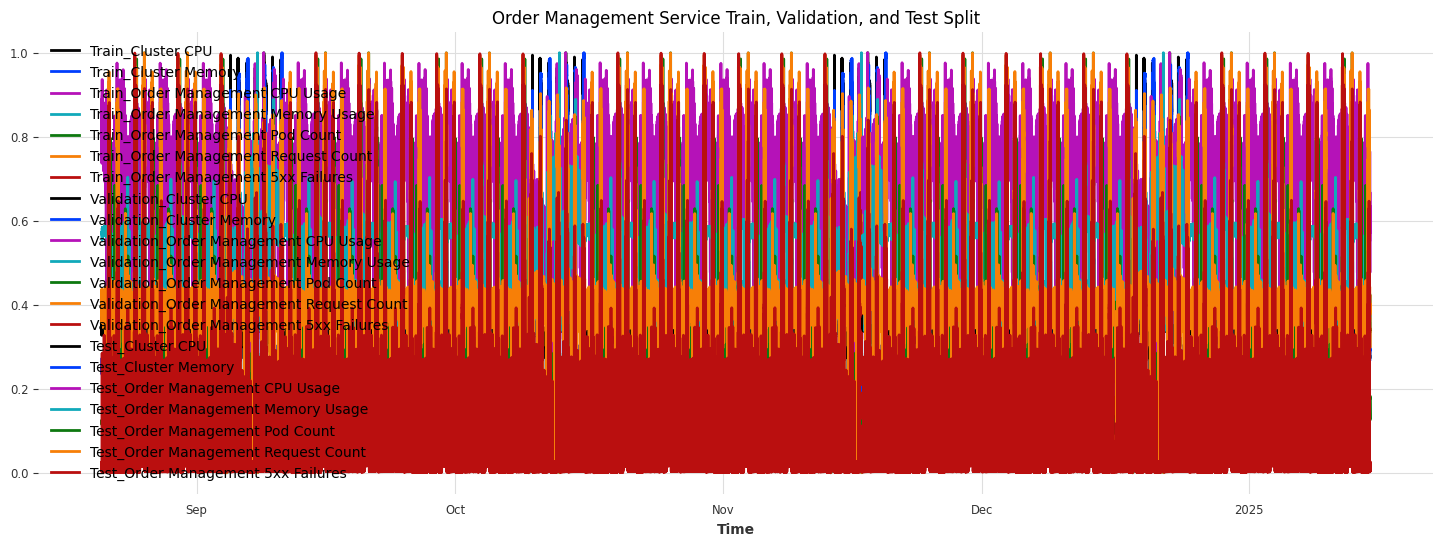

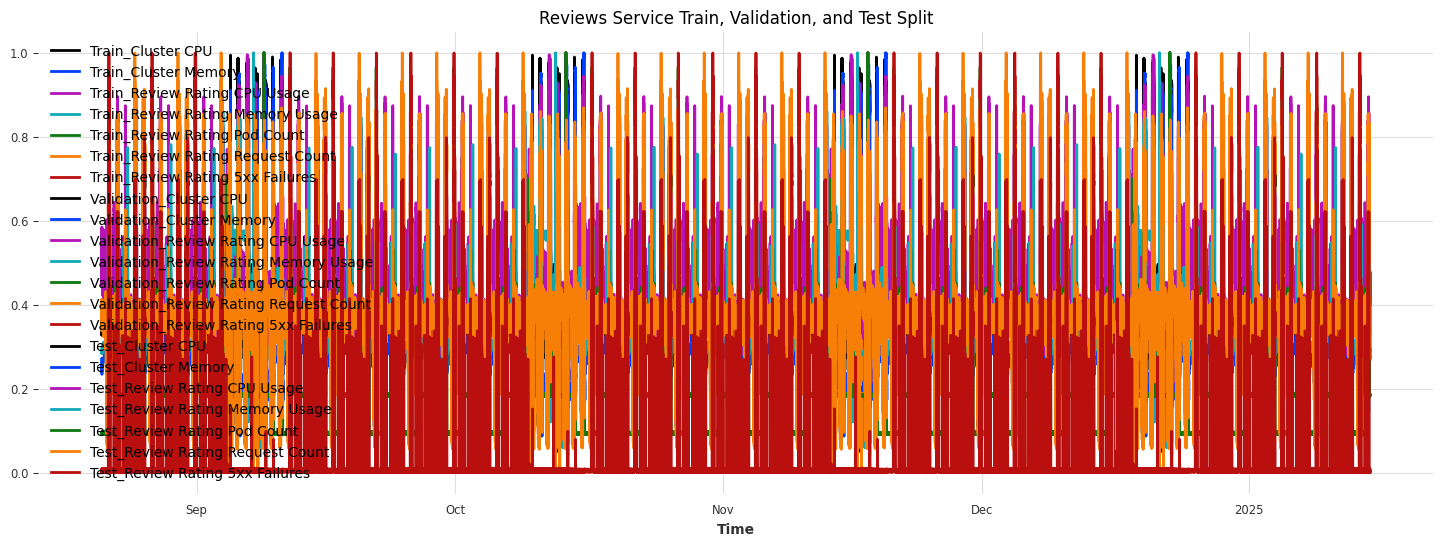

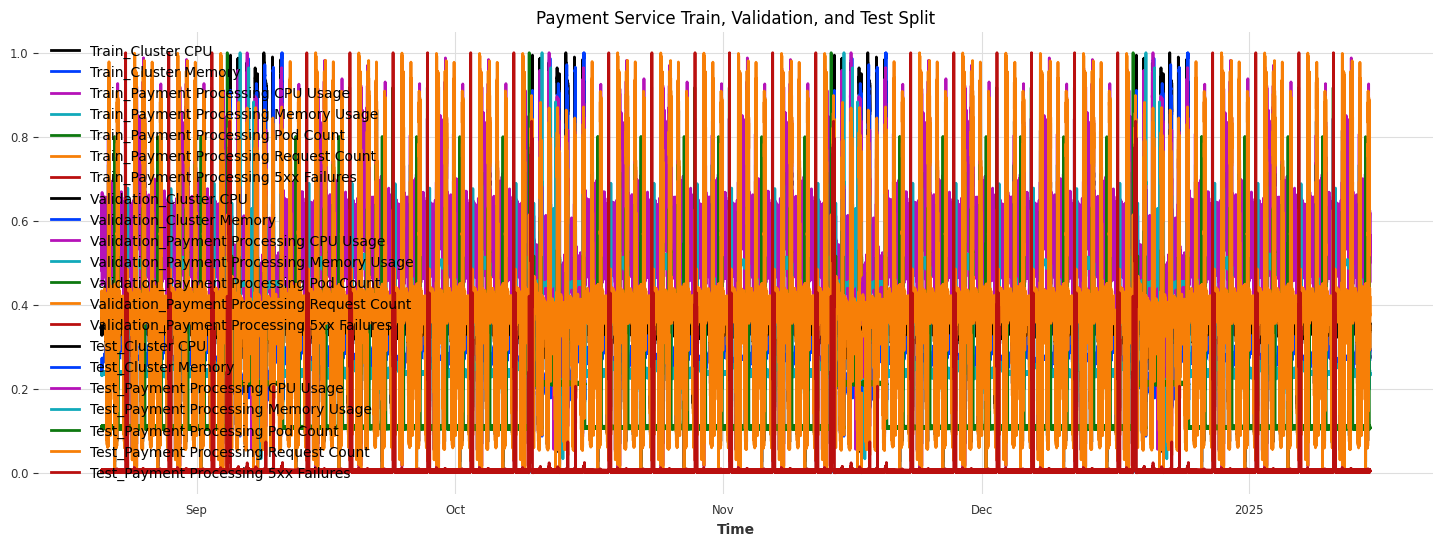

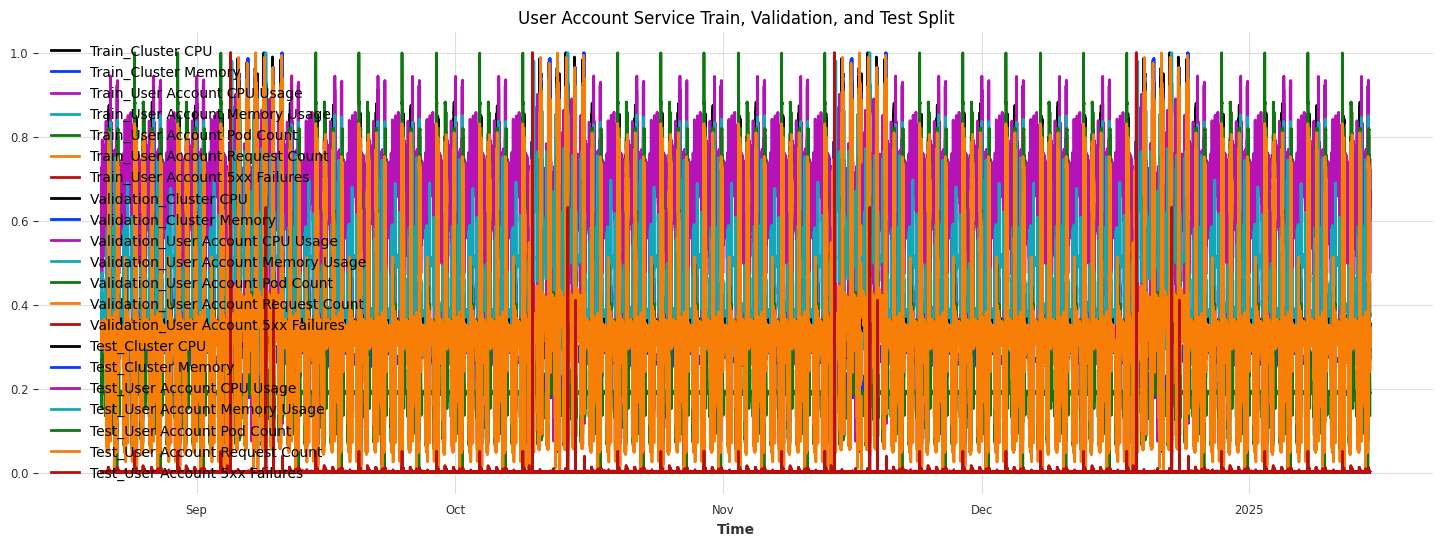

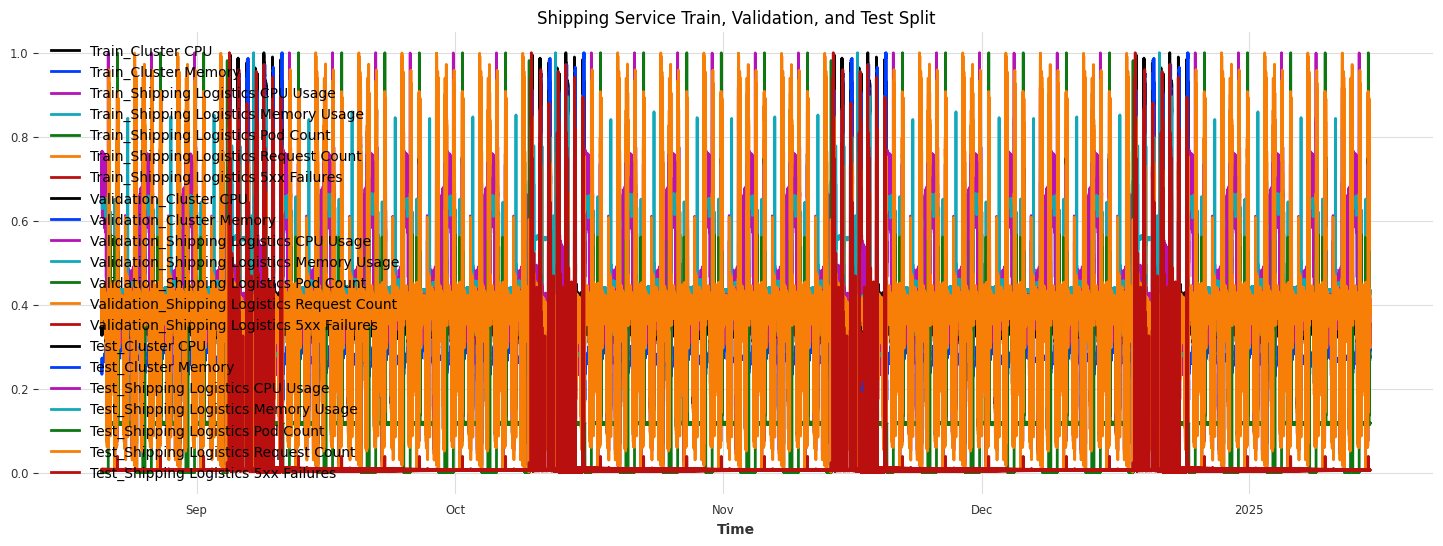

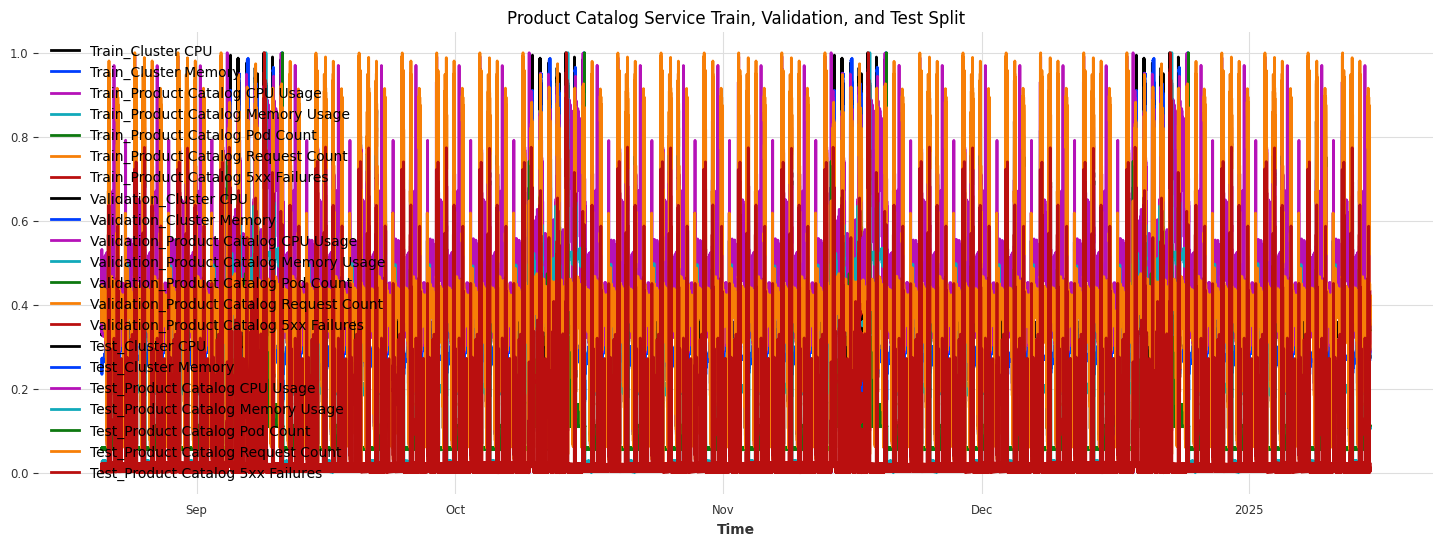

In [32]:
# 1. Order Management Service
series_cluster_cpu_order = TimeSeries.from_dataframe(order_smoothed, 'Time', 'Cluster CPU')
series_cluster_memory_order = TimeSeries.from_dataframe(order_smoothed, 'Time', 'Cluster Memory')
series_order_cpu = TimeSeries.from_dataframe(order_smoothed, 'Time', 'Order Management CPU Usage')
series_order_memory = TimeSeries.from_dataframe(order_smoothed, 'Time', 'Order Management Memory Usage')
series_order_pod_count = TimeSeries.from_dataframe(order_smoothed, 'Time', 'Order Management Pod Count')
series_order_request_count = TimeSeries.from_dataframe(order_smoothed, 'Time', 'Order Management Request Count')
series_order_5xx_failures = TimeSeries.from_dataframe(order_smoothed, 'Time', 'Order Management 5xx Failures')

# Normalize/Scale the data
scaler = Scaler(MinMaxScaler())
series_cluster_cpu_order_scaled = scaler.fit_transform(series_cluster_cpu_order)
series_cluster_memory_order_scaled = scaler.fit_transform(series_cluster_memory_order)
series_order_cpu_scaled = scaler.fit_transform(series_order_cpu)
series_order_memory_scaled = scaler.fit_transform(series_order_memory)
series_order_pod_count_scaled = scaler.fit_transform(series_order_pod_count)
series_order_request_count_scaled = scaler.fit_transform(series_order_request_count)
series_order_5xx_failures_scaled = scaler.fit_transform(series_order_5xx_failures)

# Stack the time series for multi-target forecasting
multivariate_series_order = (
    series_cluster_cpu_order_scaled.stack(series_cluster_memory_order_scaled)
    .stack(series_order_cpu_scaled)
    .stack(series_order_memory_scaled)
    .stack(series_order_pod_count_scaled)
    .stack(series_order_request_count_scaled)
    .stack(series_order_5xx_failures_scaled)
)

# Train/Test/Validation Split
train_size = 0.6  # 60% for training
val_size = 0.2  # 20% for validation
train_val_cutoff = int(train_size * len(multivariate_series_order))
val_test_cutoff = int((train_size + val_size) * len(multivariate_series_order))

# Splitting the multivariate series for Order Management
train_series_order = multivariate_series_order[:train_val_cutoff]
val_series_order = multivariate_series_order[train_val_cutoff:val_test_cutoff]
test_series_order = multivariate_series_order[val_test_cutoff:]

plt.figure(figsize=(18, 6))
train_series_order.plot(label='Train')
val_series_order.plot(label='Validation')
test_series_order.plot(label='Test')
plt.title("Order Management Service Train, Validation, and Test Split")
plt.legend()
plt.show()


# 2. Reviews Service
series_cluster_cpu_reviews = TimeSeries.from_dataframe(reviews_smoothed, 'Time', 'Cluster CPU')
series_cluster_memory_reviews = TimeSeries.from_dataframe(reviews_smoothed, 'Time', 'Cluster Memory')
series_review_cpu = TimeSeries.from_dataframe(reviews_smoothed, 'Time', 'Review Rating CPU Usage')
series_review_memory = TimeSeries.from_dataframe(reviews_smoothed, 'Time', 'Review Rating Memory Usage')
series_review_pod_count = TimeSeries.from_dataframe(reviews_smoothed, 'Time', 'Review Rating Pod Count')
series_review_request_count = TimeSeries.from_dataframe(reviews_smoothed, 'Time', 'Review Rating Request Count')
series_review_5xx_failures = TimeSeries.from_dataframe(reviews_smoothed, 'Time', 'Review Rating 5xx Failures')

# Normalize/Scale the data
scaler = Scaler(MinMaxScaler())
series_cluster_cpu_reviews_scaled = scaler.fit_transform(series_cluster_cpu_reviews)
series_cluster_memory_reviews_scaled = scaler.fit_transform(series_cluster_memory_reviews)
series_review_cpu_scaled = scaler.fit_transform(series_review_cpu)
series_review_memory_scaled = scaler.fit_transform(series_review_memory)
series_review_pod_count_scaled = scaler.fit_transform(series_review_pod_count)
series_review_request_count_scaled = scaler.fit_transform(series_review_request_count)
series_review_5xx_failures_scaled = scaler.fit_transform(series_review_5xx_failures)

# Stack the time series for multi-target forecasting
multivariate_series_reviews = (
    series_cluster_cpu_reviews_scaled.stack(series_cluster_memory_reviews_scaled)
    .stack(series_review_cpu_scaled)
    .stack(series_review_memory_scaled)
    .stack(series_review_pod_count_scaled)
    .stack(series_review_request_count_scaled)
    .stack(series_review_5xx_failures_scaled)
)

# Train/Test/Validation Split
train_val_cutoff_reviews = int(train_size * len(multivariate_series_reviews))
val_test_cutoff_reviews = int((train_size + val_size) * len(multivariate_series_reviews))

# Splitting the multivariate series for Reviews
train_series_reviews = multivariate_series_reviews[:train_val_cutoff_reviews]
val_series_reviews = multivariate_series_reviews[train_val_cutoff_reviews:val_test_cutoff_reviews]
test_series_reviews = multivariate_series_reviews[val_test_cutoff_reviews:]

plt.figure(figsize=(18, 6))
train_series_reviews.plot(label='Train')
val_series_reviews.plot(label='Validation')
test_series_reviews.plot(label='Test')
plt.title("Reviews Service Train, Validation, and Test Split")
plt.legend()
plt.show()


# 3. Payment Service
series_cluster_cpu_payment = TimeSeries.from_dataframe(payment_smoothed, 'Time', 'Cluster CPU')
series_cluster_memory_payment = TimeSeries.from_dataframe(payment_smoothed, 'Time', 'Cluster Memory')
series_payment_cpu = TimeSeries.from_dataframe(payment_smoothed, 'Time', 'Payment Processing CPU Usage')
series_payment_memory = TimeSeries.from_dataframe(payment_smoothed, 'Time', 'Payment Processing Memory Usage')
series_payment_pod_count = TimeSeries.from_dataframe(payment_smoothed, 'Time', 'Payment Processing Pod Count')
series_payment_request_count = TimeSeries.from_dataframe(payment_smoothed, 'Time', 'Payment Processing Request Count')
series_payment_5xx_failures = TimeSeries.from_dataframe(payment_smoothed, 'Time', 'Payment Processing 5xx Failures')

# Normalize/Scale the data
scaler = Scaler(MinMaxScaler())
series_cluster_cpu_payment_scaled = scaler.fit_transform(series_cluster_cpu_payment)
series_cluster_memory_payment_scaled = scaler.fit_transform(series_cluster_memory_payment)
series_payment_cpu_scaled = scaler.fit_transform(series_payment_cpu)
series_payment_memory_scaled = scaler.fit_transform(series_payment_memory)
series_payment_pod_count_scaled = scaler.fit_transform(series_payment_pod_count)
series_payment_request_count_scaled = scaler.fit_transform(series_payment_request_count)
series_payment_5xx_failures_scaled = scaler.fit_transform(series_payment_5xx_failures)

# Stack the time series for multi-target forecasting
multivariate_series_payment = (
    series_cluster_cpu_payment_scaled.stack(series_cluster_memory_payment_scaled)
    .stack(series_payment_cpu_scaled)
    .stack(series_payment_memory_scaled)
    .stack(series_payment_pod_count_scaled)
    .stack(series_payment_request_count_scaled)
    .stack(series_payment_5xx_failures_scaled)
)

# Train/Test/Validation Split
train_val_cutoff_payment = int(train_size * len(multivariate_series_payment))
val_test_cutoff_payment = int((train_size + val_size) * len(multivariate_series_payment))

# Splitting the multivariate series for Payment
train_series_payment = multivariate_series_payment[:train_val_cutoff_payment]
val_series_payment = multivariate_series_payment[train_val_cutoff_payment:val_test_cutoff_payment]
test_series_payment = multivariate_series_payment[val_test_cutoff_payment:]

plt.figure(figsize=(18, 6))
train_series_payment.plot(label='Train')
val_series_payment.plot(label='Validation')
test_series_payment.plot(label='Test')
plt.title("Payment Service Train, Validation, and Test Split")
plt.legend()
plt.show()


# 4. User Management Service
series_cluster_cpu_user = TimeSeries.from_dataframe(user_smoothed, 'Time', 'Cluster CPU')
series_cluster_memory_user = TimeSeries.from_dataframe(user_smoothed, 'Time', 'Cluster Memory')
series_user_cpu = TimeSeries.from_dataframe(user_smoothed, 'Time', 'User Account CPU Usage')
series_user_memory = TimeSeries.from_dataframe(user_smoothed, 'Time', 'User Account Memory Usage')
series_user_pod_count = TimeSeries.from_dataframe(user_smoothed, 'Time', 'User Account Pod Count')
series_user_request_count = TimeSeries.from_dataframe(user_smoothed, 'Time', 'User Account Request Count')
series_user_5xx_failures = TimeSeries.from_dataframe(user_smoothed, 'Time', 'User Account 5xx Failures')

# Normalize/Scale the data
scaler = Scaler(MinMaxScaler())
series_cluster_cpu_user_scaled = scaler.fit_transform(series_cluster_cpu_user)
series_cluster_memory_user_scaled = scaler.fit_transform(series_cluster_memory_user)
series_user_cpu_scaled = scaler.fit_transform(series_user_cpu)
series_user_memory_scaled = scaler.fit_transform(series_user_memory)
series_user_pod_count_scaled = scaler.fit_transform(series_user_pod_count)
series_user_request_count_scaled = scaler.fit_transform(series_user_request_count)
series_user_5xx_failures_scaled = scaler.fit_transform(series_user_5xx_failures)

# Stack the time series for multi-target forecasting
multivariate_series_user = (
    series_cluster_cpu_user_scaled.stack(series_cluster_memory_user_scaled)
    .stack(series_user_cpu_scaled)
    .stack(series_user_memory_scaled)
    .stack(series_user_pod_count_scaled)
    .stack(series_user_request_count_scaled)
    .stack(series_user_5xx_failures_scaled)
)

# Train/Test/Validation Split
train_val_cutoff_user = int(train_size * len(multivariate_series_user))
val_test_cutoff_user = int((train_size + val_size) * len(multivariate_series_user))

# Splitting the multivariate series for User Management
train_series_user = multivariate_series_user[:train_val_cutoff_user]
val_series_user = multivariate_series_user[train_val_cutoff_user:val_test_cutoff_user]
test_series_user = multivariate_series_user[val_test_cutoff_user:]

plt.figure(figsize=(18, 6))
train_series_user.plot(label='Train')
val_series_user.plot(label='Validation')
test_series_user.plot(label='Test')
plt.title("User Account Service Train, Validation, and Test Split")
plt.legend()
plt.show()


# 5. Shipping Service
series_cluster_cpu_shipping = TimeSeries.from_dataframe(shipping_smoothed, 'Time', 'Cluster CPU')
series_cluster_memory_shipping = TimeSeries.from_dataframe(shipping_smoothed, 'Time', 'Cluster Memory')
series_shipping_cpu = TimeSeries.from_dataframe(shipping_smoothed, 'Time', 'Shipping Logistics CPU Usage')
series_shipping_memory = TimeSeries.from_dataframe(shipping_smoothed, 'Time', 'Shipping Logistics Memory Usage')
series_shipping_pod_count = TimeSeries.from_dataframe(shipping_smoothed, 'Time', 'Shipping Logistics Pod Count')
series_shipping_request_count = TimeSeries.from_dataframe(shipping_smoothed, 'Time', 'Shipping Logistics Request Count')
series_shipping_5xx_failures = TimeSeries.from_dataframe(shipping_smoothed, 'Time', 'Shipping Logistics 5xx Failures')

# Normalize/Scale the data
scaler = Scaler(MinMaxScaler())
series_cluster_cpu_shipping_scaled = scaler.fit_transform(series_cluster_cpu_shipping)
series_cluster_memory_shipping_scaled = scaler.fit_transform(series_cluster_memory_shipping)
series_shipping_cpu_scaled = scaler.fit_transform(series_shipping_cpu)
series_shipping_memory_scaled = scaler.fit_transform(series_shipping_memory)
series_shipping_pod_count_scaled = scaler.fit_transform(series_shipping_pod_count)
series_shipping_request_count_scaled = scaler.fit_transform(series_shipping_request_count)
series_shipping_5xx_failures_scaled = scaler.fit_transform(series_shipping_5xx_failures)

# Stack the time series for multi-target forecasting
multivariate_series_shipping = (
    series_cluster_cpu_shipping_scaled.stack(series_cluster_memory_shipping_scaled)
    .stack(series_shipping_cpu_scaled)
    .stack(series_shipping_memory_scaled)
    .stack(series_shipping_pod_count_scaled)
    .stack(series_shipping_request_count_scaled)
    .stack(series_shipping_5xx_failures_scaled)
)

# Train/Test/Validation Split
train_val_cutoff_shipping = int(train_size * len(multivariate_series_shipping))
val_test_cutoff_shipping = int((train_size + val_size) * len(multivariate_series_shipping))

# Splitting the multivariate series for Inventory
train_series_shipping = multivariate_series_shipping[:train_val_cutoff_shipping]
val_series_shipping = multivariate_series_shipping[train_val_cutoff_shipping:val_test_cutoff_shipping]
test_series_shipping = multivariate_series_shipping[val_test_cutoff_shipping:]

plt.figure(figsize=(18, 6))
train_series_shipping.plot(label='Train')
val_series_shipping.plot(label='Validation')
test_series_shipping.plot(label='Test')
plt.title("Shipping Service Train, Validation, and Test Split")
plt.legend()
plt.show()

# 6. Product Catalog Service
series_cluster_cpu_product = TimeSeries.from_dataframe(product_smoothed, 'Time', 'Cluster CPU')
series_cluster_memory_product = TimeSeries.from_dataframe(product_smoothed, 'Time', 'Cluster Memory')
series_product_cpu = TimeSeries.from_dataframe(product_smoothed, 'Time', 'Product Catalog CPU Usage')
series_product_memory = TimeSeries.from_dataframe(product_smoothed, 'Time', 'Product Catalog Memory Usage')
series_product_pod_count = TimeSeries.from_dataframe(product_smoothed, 'Time', 'Product Catalog Pod Count')
series_product_request_count = TimeSeries.from_dataframe(product_smoothed, 'Time', 'Product Catalog Request Count')
series_product_5xx_failures = TimeSeries.from_dataframe(product_smoothed, 'Time', 'Product Catalog 5xx Failures')

# Normalize/Scale the data
scaler = Scaler(MinMaxScaler())
series_cluster_cpu_product_scaled = scaler.fit_transform(series_cluster_cpu_product)
series_cluster_memory_product_scaled = scaler.fit_transform(series_cluster_memory_product)
series_product_cpu_scaled = scaler.fit_transform(series_product_cpu)
series_product_memory_scaled = scaler.fit_transform(series_product_memory)
series_product_pod_count_scaled = scaler.fit_transform(series_product_pod_count)
series_product_request_count_scaled = scaler.fit_transform(series_product_request_count)
series_product_5xx_failures_scaled = scaler.fit_transform(series_product_5xx_failures)

# Stack the time series for multi-target forecasting
multivariate_series_product = (
    series_cluster_cpu_product_scaled.stack(series_cluster_memory_product_scaled)
    .stack(series_product_cpu_scaled)
    .stack(series_product_memory_scaled)
    .stack(series_product_pod_count_scaled)
    .stack(series_product_request_count_scaled)
    .stack(series_product_5xx_failures_scaled)
)

# Train/Test/Validation Split
train_val_cutoff_product = int(train_size * len(multivariate_series_product))
val_test_cutoff_product = int((train_size + val_size) * len(multivariate_series_product))

# Splitting the multivariate series for Product Catalog
train_series_product = multivariate_series_product[:train_val_cutoff_product]
val_series_product = multivariate_series_product[train_val_cutoff_product:val_test_cutoff_product]
test_series_product = multivariate_series_product[val_test_cutoff_product:]

plt.figure(figsize=(18, 6))
train_series_product.plot(label='Train')
val_series_product.plot(label='Validation')
test_series_product.plot(label='Test')
plt.title("Product Catalog Service Train, Validation, and Test Split")
plt.legend()
plt.show()


In [33]:
# Define a function to train a model
def train_model(train_series, val_series, model_name):
    model = NHiTSModel(model_name=model_name, **nhits_model_args)
    pl_trainer = pl.Trainer(**pl_trainer_kwargs)

    # Fit the model
    model.fit(
        series=train_series,
        val_series=val_series,
        verbose=True,
    )

    # Load the model from its best state/checkpoint
    model = model.load_from_checkpoint(model_name=model_name, best=True)

    # Save the model
    model.save(os.path.join(model_dir, f"{model_name}.pt"))

    return model

# Define all feature series
train_series_dict = {
    "5xx_failures": (train_series_5xx_failures, val_series_5xx_failures),
    "request_count": (train_series_request_count, val_series_request_count),
    "memory": (train_series_memory, val_series_memory),
    "cpu": (train_series_cpu, val_series_cpu),
    "pod_count": (train_series_pod_count, val_series_pod_count),
}

# Define and train univariate models for cluster CPU and memory
univariate_series_dict = {
    "cluster_cpu": (train_series_cluster_cpu, val_series_cluster_cpu),
    "cluster_memory": (train_series_cluster_memory, val_series_cluster_memory)
}

In [214]:
# Loop through each feature and train the models
for feature_name, (train_series, val_series) in train_series_dict.items():
    # Train the model
    model_name = f"{feature_name}_model"
    model = train_model(train_series, val_series, model_name)

for feature_name, (train_series, val_series) in univariate_series_dict.items():
    # Train the univariate model
    model_name = f"{feature_name}_model"
    model = train_model(train_series, val_series, model_name)

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

### Inference and Plotting

Predicting: |                                                                                                 …

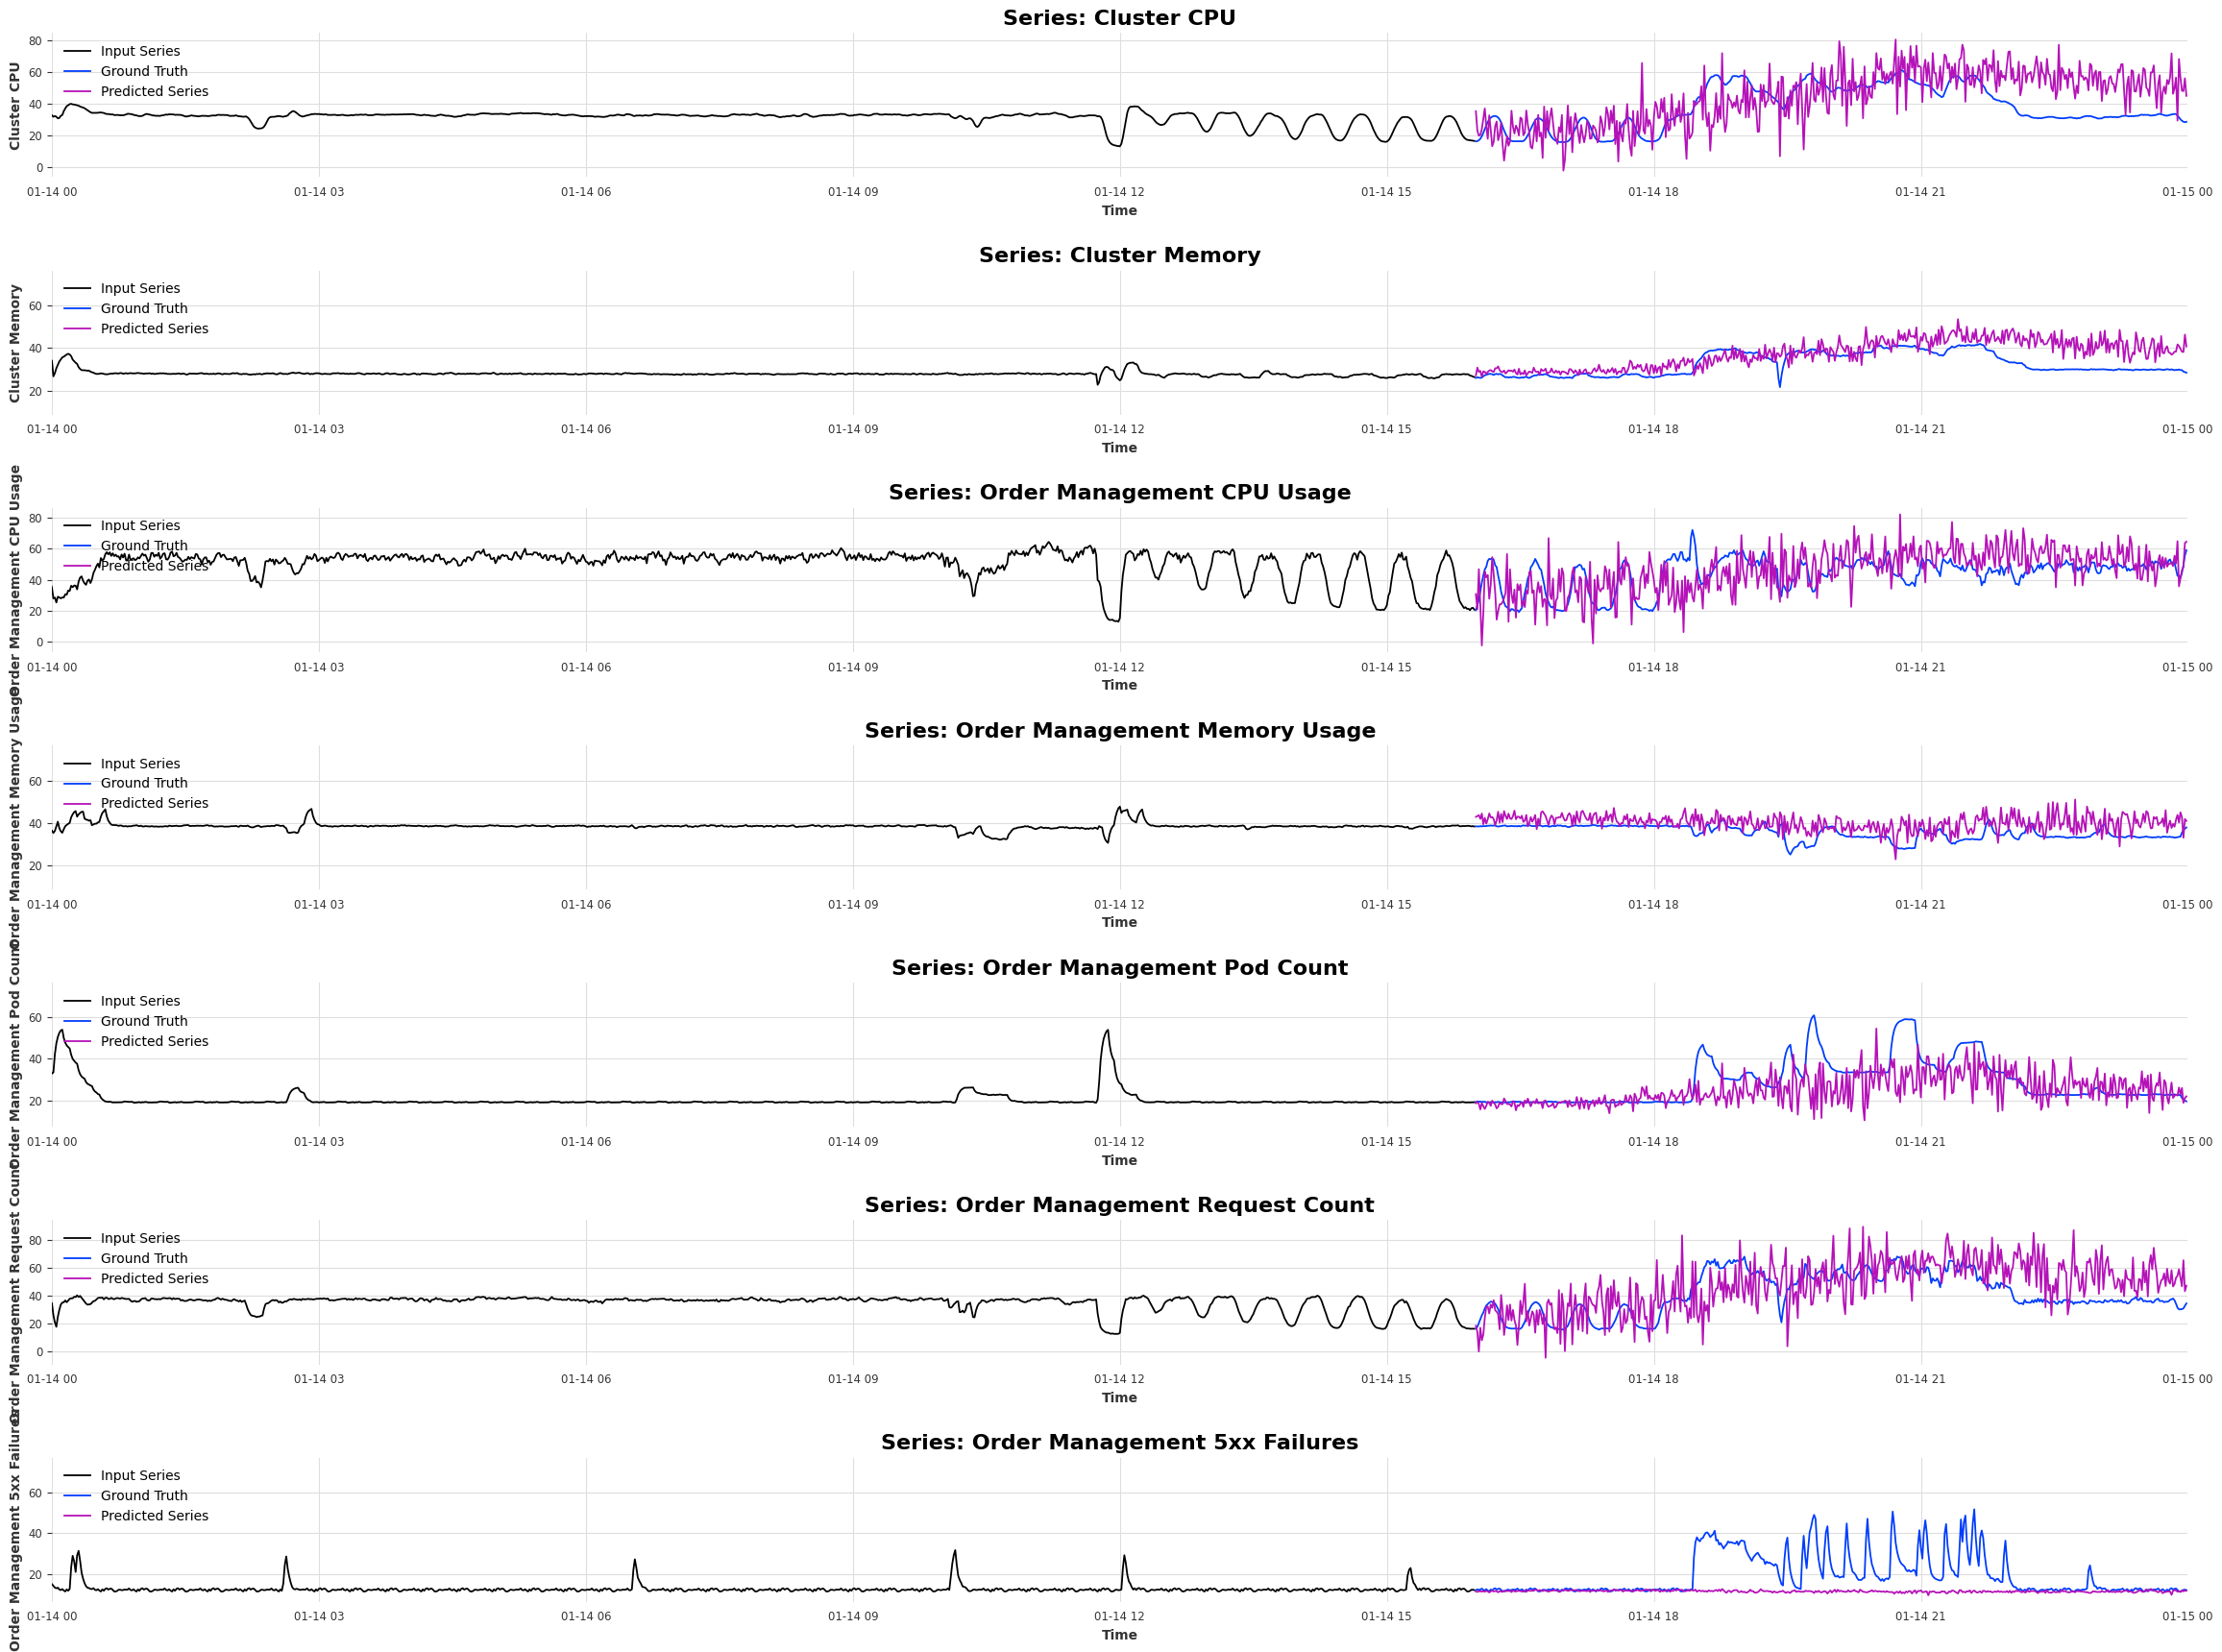

In [54]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from darts.models import NHiTSModel
import pandas as pd
from datetime import datetime

# Prediction steps
pred_steps = 480

# Define the prediction date range
start_date = datetime(2025, 1, 14)
end_date = datetime(2025, 1, 15)

# Prepare a dictionary for models based on your feature-centric approach
models_dict = {
    "5xx_failures": NHiTSModel.load(os.path.join(model_dir, "5xx_failures_model.pt")),
    "request_count": NHiTSModel.load(os.path.join(model_dir, "request_count_model.pt")),
    "memory": NHiTSModel.load(os.path.join(model_dir, "memory_model.pt")),
    "cpu": NHiTSModel.load(os.path.join(model_dir, "cpu_model.pt")),
    "pod_count": NHiTSModel.load(os.path.join(model_dir, "pod_count_model.pt")),
    "cluster_cpu": NHiTSModel.load(os.path.join(model_dir, "cluster_cpu_model.pt")),
    "cluster_memory": NHiTSModel.load(os.path.join(model_dir, "cluster_memory_model.pt")),
}

# Prepare a dictionary for input and ground truth series
test_series_dict = {
    "5xx_failures": test_series_5xx_failures,
    "request_count": test_series_request_count,
    "memory": test_series_memory,
    "cpu": test_series_cpu,
    "pod_count": test_series_pod_count,
    "cluster_cpu": test_series_cluster_cpu,
    "cluster_memory": test_series_cluster_memory,
}

# Explicit mapping of feature names to their corresponding column names in your data
column_name_mapping = {
    "5xx_failures": [
        "Order Management 5xx Failures",
        "Review Rating 5xx Failures",
        "Payment Processing 5xx Failures",
        "User Account 5xx Failures",
        "Shipping Logistics 5xx Failures",
        "Product Catalog 5xx Failures"
    ],
    "request_count": [
        "Order Management Request Count",
        "Review Rating Request Count",
        "Payment Processing Request Count",
        "User Account Request Count",
        "Shipping Logistics Request Count",
        "Product Catalog Request Count"
    ],
    "memory": [
        "Order Management Memory Usage",
        "Review Rating Memory Usage",
        "Payment Processing Memory Usage",
        "User Account Memory Usage",
        "Shipping Logistics Memory Usage",
        "Product Catalog Memory Usage"
    ],
    "cpu": [
        "Order Management CPU Usage",
        "Review Rating CPU Usage",
        "Payment Processing CPU Usage",
        "User Account CPU Usage",
        "Shipping Logistics CPU Usage",
        "Product Catalog CPU Usage"
    ],
    "pod_count": [
        "Order Management Pod Count",
        "Review Rating Pod Count",
        "Payment Processing Pod Count",
        "User Account Pod Count",
        "Shipping Logistics Pod Count",
        "Product Catalog Pod Count"
    ],
    "cluster_cpu": [
        "Cluster CPU"
    ],
    "cluster_memory": [
        "Cluster Memory"
    ]
}

# Create a 7x1 subplot to visualize the series
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(14, 20))
fig.tight_layout(pad=5.0)

# Define a dictionary for scalers
scalers_dict = {
    "5xx_failures": scaler_5xx_failures,
    "request_count": scaler_request_count,
    "memory": scaler_memory,
    "cpu": scaler_cpu,
    "pod_count": scaler_pod_count,
    "cluster_cpu": scaler_cluster_cpu,
    "cluster_memory": scaler_cluster_memory,
}

# Loop through each feature and perform predictions
for idx, (feature_name, model) in enumerate(models_dict.items()):
    # Prepare the input and ground truth series
    pred_input = test_series_dict[feature_name][:-pred_steps]  # Input data for prediction
    ground_truth = test_series_dict[feature_name][-pred_steps:]  # Actual future data

    # Get the appropriate scaler for this feature
    scaler = scalers_dict[feature_name]
    
    # Predict the next `pred_steps` points
    pred_series = model.predict(n=pred_steps, series=pred_input)

    # Inverse transform the series to get actual values
    input_series = scaler.inverse_transform(pred_input).pd_dataframe()
    ground_series = scaler.inverse_transform(ground_truth).pd_dataframe()
    predicted_series = scaler.inverse_transform(pred_series).pd_dataframe()

    # Loop through all columns for this feature and plot each one
    for column in column_name_mapping[feature_name]:
        # Plotting the series and include the model name in the label
        sns.lineplot(ax=axes[idx], x=input_series.index, y=input_series[column], label=f'Input Series ({feature_name}) - {column}', color='blue')
        sns.lineplot(ax=axes[idx], x=ground_series.index, y=ground_series[column], label=f'Ground Truth ({feature_name}) - {column}', color='green')
        sns.lineplot(ax=axes[idx], x=predicted_series.index, y=predicted_series[column], label=f'Predicted Series ({feature_name}) - {column}', color='red')

    axes[idx].set_title(f"Feature: {feature_name}")
    axes[idx].legend(loc='upper left')
    # axes[idx].set_xlim(left=start_date, right=end_date)

# Display the plot
plt.savefig('Final Predictions.png')
plt.show()


## Feature Centric Modeling and Prediction

In [2]:
import torch
import os
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from darts import TimeSeries
from darts.models import NHiTSModel
from darts.utils.likelihood_models import GaussianLikelihood
from sklearn.preprocessing import MinMaxScaler
from darts.dataprocessing.transformers import Scaler
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl

import warnings

warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


# Define the columns to include in the new DataFrame
order_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'Order Management CPU Usage',
    'Order Management Memory Usage',
    'Order Management Request Count',
    'Order Management 5xx Failures',
    'Order Management Pod Count'
]
product_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'Product Catalog CPU Usage',
    'Product Catalog Memory Usage',
    'Product Catalog Request Count',
    'Product Catalog 5xx Failures',
    'Product Catalog Pod Count'
]
shipping_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'Shipping Logistics CPU Usage',
    'Shipping Logistics Memory Usage',
    'Shipping Logistics Request Count',
    'Shipping Logistics 5xx Failures',
    'Shipping Logistics Pod Count'
]
user_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'User Account CPU Usage',
    'User Account Memory Usage',
    'User Account Request Count',
    'User Account 5xx Failures',
    'User Account Pod Count'
]
reviews_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'Review Rating CPU Usage',
    'Review Rating Memory Usage',
    'Review Rating Request Count',
    'Review Rating 5xx Failures',
    'Review Rating Pod Count'
]
payment_columns_to_include = [
    'Time',
    'Cluster CPU',
    'Cluster Memory',
    'Payment Processing CPU Usage',
    'Payment Processing Memory Usage',
    'Payment Processing Request Count',
    'Payment Processing 5xx Failures',
    'Payment Processing Pod Count'
]

file_path = '~/Downloads/Extended_Collected_Data.csv'

# Creating dataframes for each service
order_df = pd.read_csv(file_path, usecols=order_columns_to_include)
product_df = pd.read_csv(file_path, usecols=product_columns_to_include)
user_df = pd.read_csv(file_path, usecols=user_columns_to_include)
reviews_df = pd.read_csv(file_path, usecols=reviews_columns_to_include)
shipping_df = pd.read_csv(file_path, usecols=shipping_columns_to_include)
payment_df = pd.read_csv(file_path, usecols=payment_columns_to_include)

order_df.fillna(0, inplace=True)
product_df.fillna(0, inplace=True)
user_df.fillna(0, inplace=True)
reviews_df.fillna(0, inplace=True)
shipping_df.fillna(0, inplace=True)
payment_df.fillna(0, inplace=True)


# Convert 'Timestamp [ms]' to datetime and set it as the index
order_df['Time'] = pd.to_datetime(order_df['Time'])
order_df.set_index('Time', inplace=True)
order_df['Time'] = order_df.index
order_df.head()

product_df['Time'] = pd.to_datetime(product_df['Time'])
product_df.set_index('Time', inplace=True)
product_df['Time'] = product_df.index
product_df.head()

user_df['Time'] = pd.to_datetime(user_df['Time'])
user_df.set_index('Time', inplace=True)
user_df['Time'] = user_df.index
user_df.head()

reviews_df['Time'] = pd.to_datetime(reviews_df['Time'])
reviews_df.set_index('Time', inplace=True)
reviews_df['Time'] = reviews_df.index
reviews_df.head()

shipping_df['Time'] = pd.to_datetime(shipping_df['Time'])
shipping_df.set_index('Time', inplace=True)
shipping_df['Time'] = shipping_df.index
shipping_df.head()

payment_df['Time'] = pd.to_datetime(payment_df['Time'])
payment_df.set_index('Time', inplace=True)
payment_df['Time'] = payment_df.index
payment_df.head()

order_df.head()

Cluster CPU  Cluster Memory  Order Management CPU Usage  \
Time                                                                           
2024-08-21 00:00:00         15.3            22.2                        50.1   
2024-08-21 00:01:00         16.4            22.4                        48.3   
2024-08-21 00:02:00         17.3            22.4                        37.4   
2024-08-21 00:03:00         17.7            22.3                        48.4   
2024-08-21 00:04:00         17.0            22.3                        45.2   

                     Order Management Memory Usage  \
Time                                                 
2024-08-21 00:00:00                           50.0   
2024-08-21 00:01:00                           50.0   
2024-08-21 00:02:00                           50.0   
2024-08-21 00:03:00                           50.0   
2024-08-21 00:04:00                           50.0   

                     Order Management Pod Count  \
Time                                              
2024-08-21 00:00:00                           3   
2024-08-21 00:01:00                           3   
2024-08-21 00:02:00                           3   
2024-08-21 00:03:00                           3   
2024-08-21 00:04:00                           3   

                     Order Management Request Count  \
Time                                                  
2024-08-21 00:00:00                            7498   
2024-08-21 00:01:00                            7486   
2024-08-21 00:02:00                            8026   
2024-08-21 00:03:00                            7586   
2024-08-21 00:04:00                            7330   

                     Order Management 5xx Failures                Time  
Time                                                                    
2024-08-21 00:00:00                         7060.0 2024-08-21 00:00:00  
2024-08-21 00:01:00                         7172.0 2024-08-21 00:01:00  
2024-08-21 00:02:00                         7846.0 2024-08-21 00:02:00  
2024-08-21 00:03:00                         7530.0 2024-08-21 00:03:00  
2024-08-21 00:04:00                         7302.0 2024-08-21 00:04:00

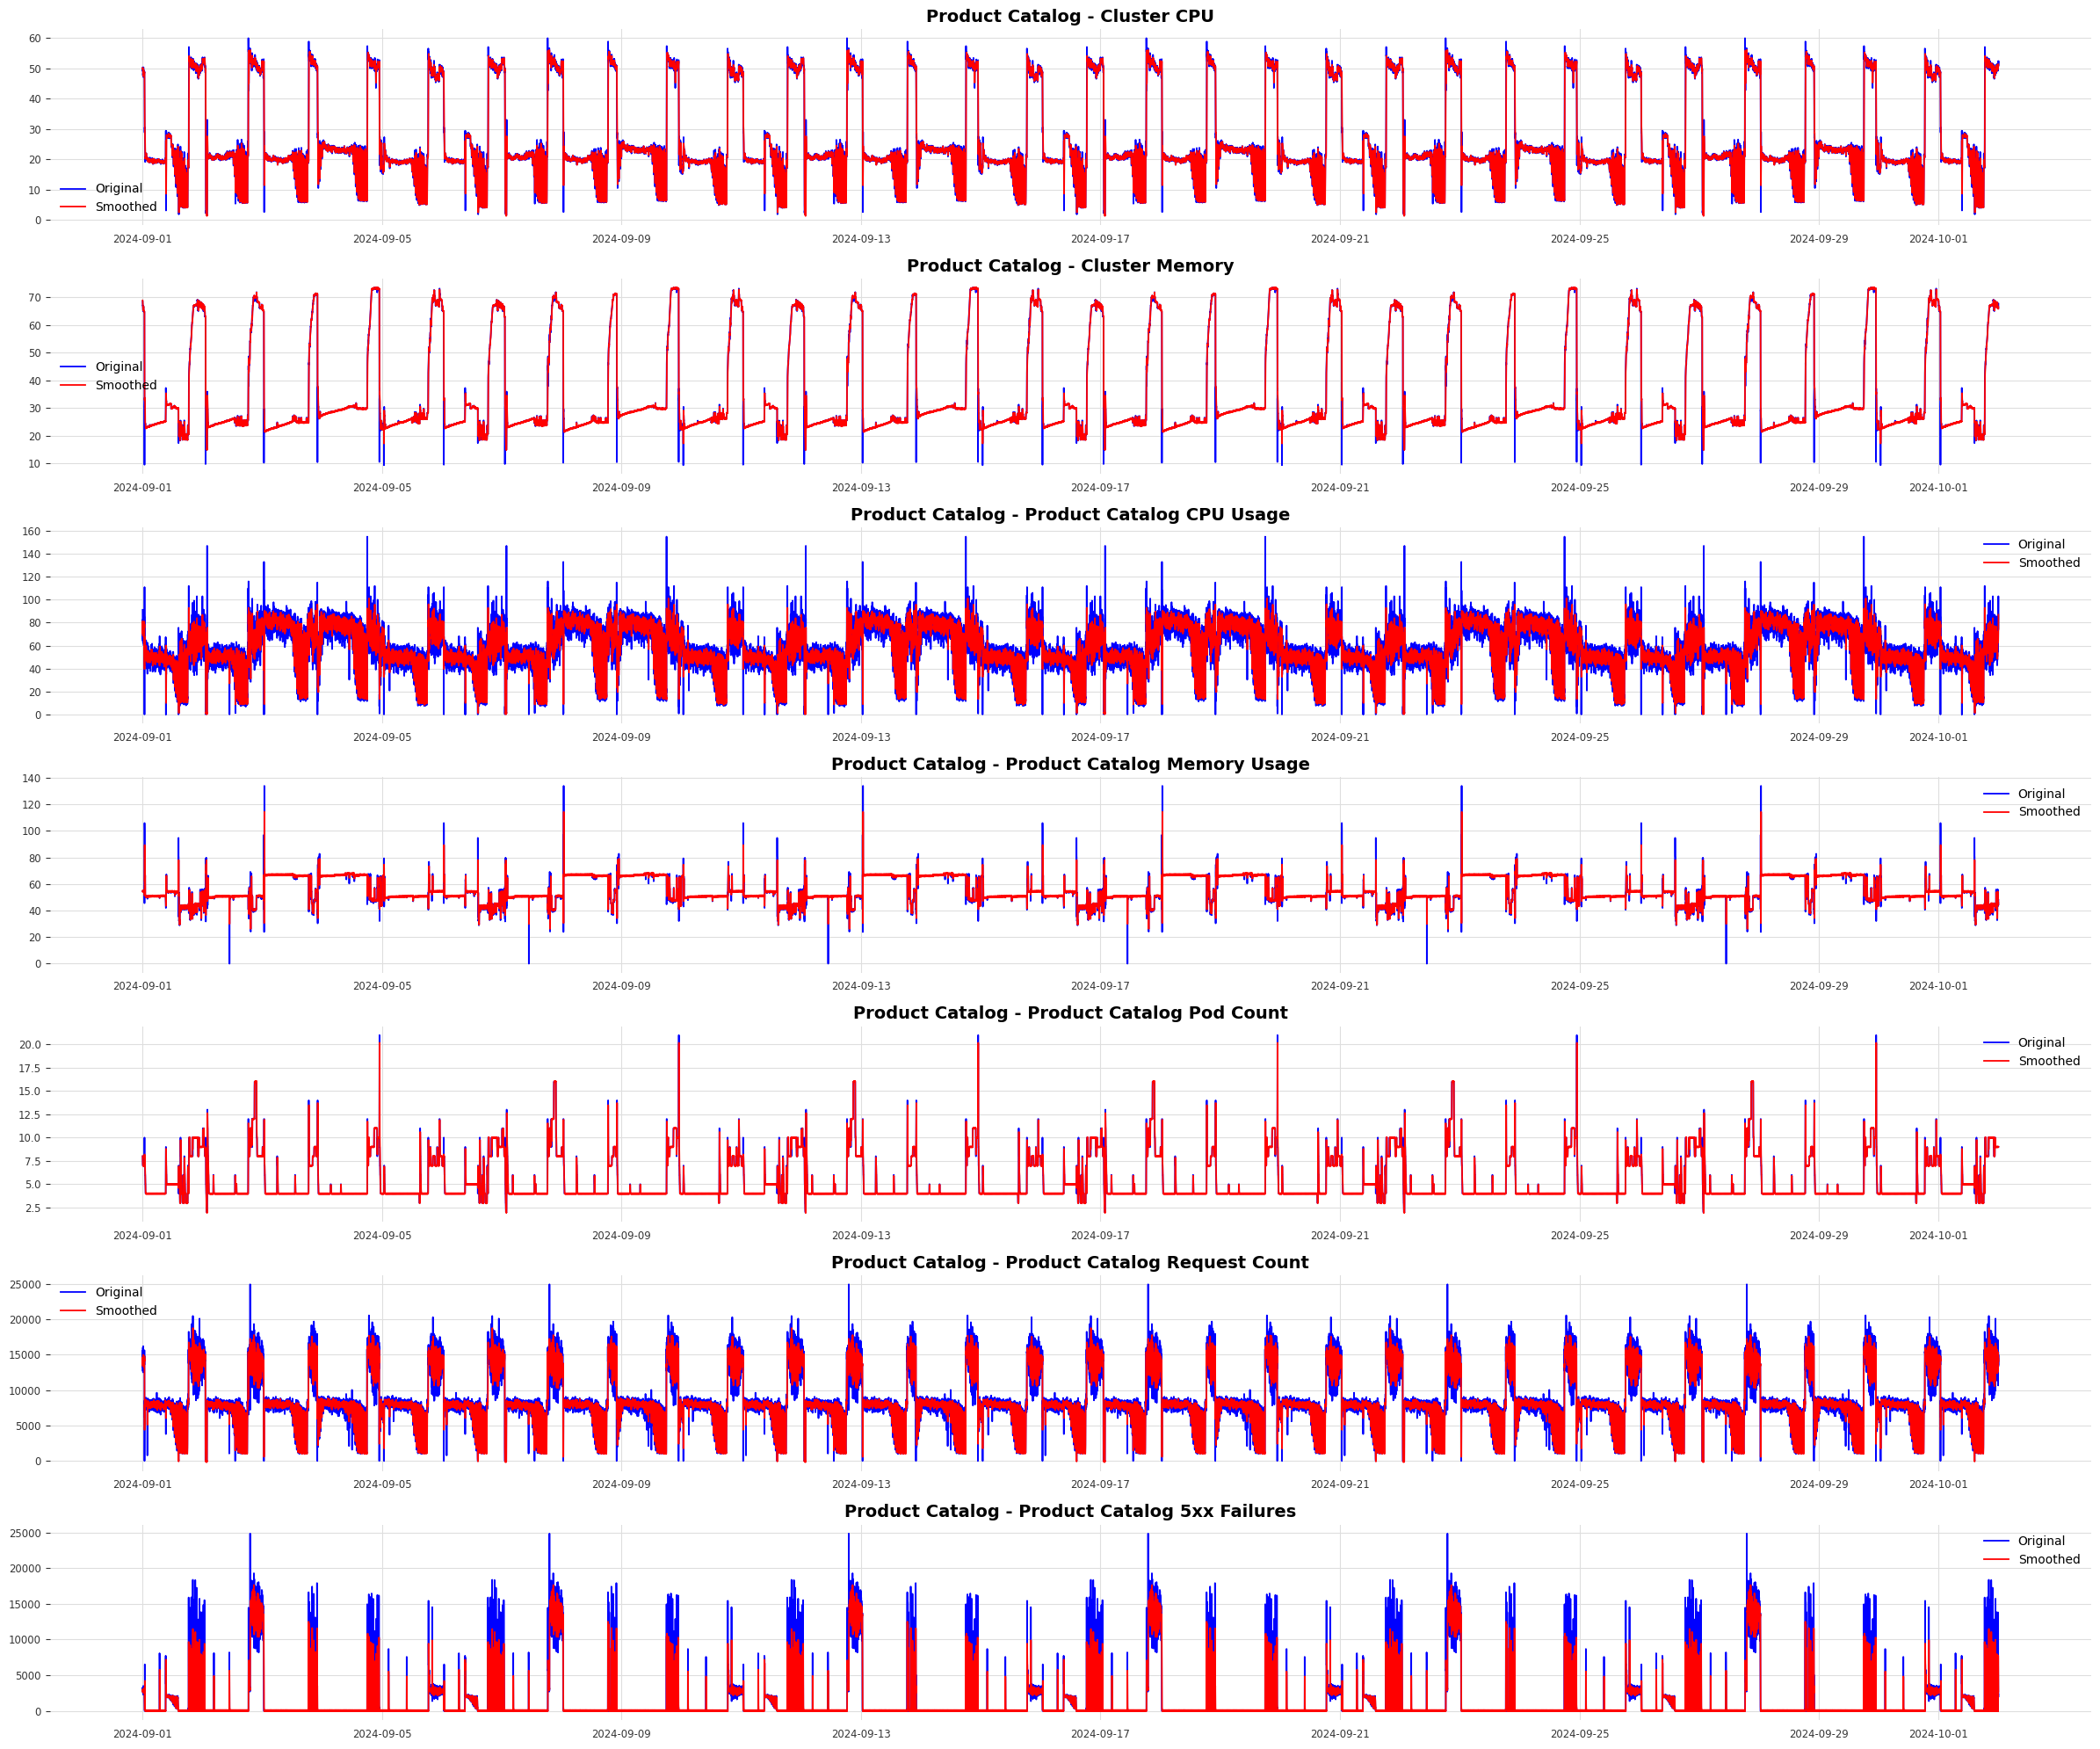

NameError: name 'payment_smoothed' is not defined

In [10]:

# Function to apply triple exponential smoothing on each column
def apply_triple_exponential_smoothing(df, seasonal_periods, trend_type='add', seasonal_type='add'):
    smoothed_df = pd.DataFrame(index=df.index)
    
    for column in df.columns:
        if column != 'Time':  # Avoid applying smoothing to the 'Time' column
            model = ExponentialSmoothing(df[column],
                                         trend=trend_type,
                                         seasonal=seasonal_type,
                                         seasonal_periods=seasonal_periods)
            smoothed_series = model.fit(smoothing_level=0.4, smoothing_trend=0.001, smoothing_seasonal=0.001).fittedvalues
            smoothed_df[column] = smoothed_series
            
    return smoothed_df

def plot_original_vs_smoothed(df, smoothed_df, title):
    # Define the time range
    start_date = '2024-09-01'
    end_date = '2024-10-01'
    
    # Filter the DataFrames for the specified time range
    df_filtered = df.loc[start_date:end_date]
    smoothed_df_filtered = smoothed_df.loc[start_date:end_date]
    
    plt.figure(figsize=(24, 20))
    columns = df.columns[:-1]  # Exclude 'Time' column
    
    for i, column in enumerate(columns, start=1):
        plt.subplot(7, 1, i)  # Adjust the subplot grid if necessary
        # Use "tab:blue" for the original plot and "tab:orange" for the smoothed plot
        plt.plot(df_filtered.index, df_filtered[column], label='Original', color='tab:blue')  
        plt.plot(smoothed_df_filtered.index, smoothed_df_filtered[column], label='Smoothed', color='tab:orange')
        plt.title(f"{title} - {column}", fontsize=14, weight='bold')  # Bold titles for better readability
        plt.legend()

    plt.tight_layout()
    plt.savefig(f"{title} - Denoising.png", dpi=300, bbox_inches='tight')  # Save with high resolution
    plt.show()


seasonal_periods = 24

# Apply smoothing and visualize for each service
# order_smoothed = apply_triple_exponential_smoothing(order_df, seasonal_periods)
# plot_original_vs_smoothed(order_df, order_smoothed, 'Order Management')

product_smoothed = apply_triple_exponential_smoothing(product_df, seasonal_periods)
plot_original_vs_smoothed(product_df, product_smoothed, 'Product Catalog')

# user_smoothed = apply_triple_exponential_smoothing(user_df, seasonal_periods)
# plot_original_vs_smoothed(user_df, user_smoothed, 'User Account')

# reviews_smoothed = apply_triple_exponential_smoothing(reviews_df, seasonal_periods)
# plot_original_vs_smoothed(reviews_df, reviews_smoothed, 'Review Rating')

# shipping_smoothed = apply_triple_exponential_smoothing(shipping_df, seasonal_periods)
# plot_original_vs_smoothed(shipping_df, shipping_smoothed, 'Shipping Logistics')

# payment_smoothed = apply_triple_exponential_smoothing(payment_df, seasonal_periods)
# plot_original_vs_smoothed(payment_df, payment_smoothed, 'Payment Processing')

order_smoothed['Time'] = order_smoothed.index
product_smoothed['Time'] = product_smoothed.index
user_smoothed['Time'] = user_smoothed.index
reviews_smoothed['Time'] = reviews_smoothed.index
shipping_smoothed['Time'] = shipping_smoothed.index
payment_smoothed['Time'] = payment_smoothed.index

In [3]:
user_smoothed.to_csv("smoothed-user-service.csv")
product_smoothed.to_csv("smoothed-product-service.csv")
order_smoothed.to_csv("smoothed-order-service.csv")
reviews_smoothed.to_csv("smoothed-reviews-service.csv")
payment_smoothed.to_csv("smoothed-payment-service.csv")
shipping_smoothed.to_csv("smoothed-shipping-service.csv")

### Actual Training

In [4]:
import torch
import os
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from darts import TimeSeries
from darts.models import NHiTSModel
from darts.utils.likelihood_models import GaussianLikelihood
from sklearn.preprocessing import MinMaxScaler
from darts.dataprocessing.transformers import Scaler
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl

user_smoothed = pd.read_csv("smoothed-user-service.csv")
product_smoothed = pd.read_csv("smoothed-product-service.csv")
order_smoothed = pd.read_csv("smoothed-order-service.csv")
reviews_smoothed = pd.read_csv("smoothed-reviews-service.csv")
payment_smoothed = pd.read_csv("smoothed-payment-service.csv")
shipping_smoothed = pd.read_csv("smoothed-shipping-service.csv")

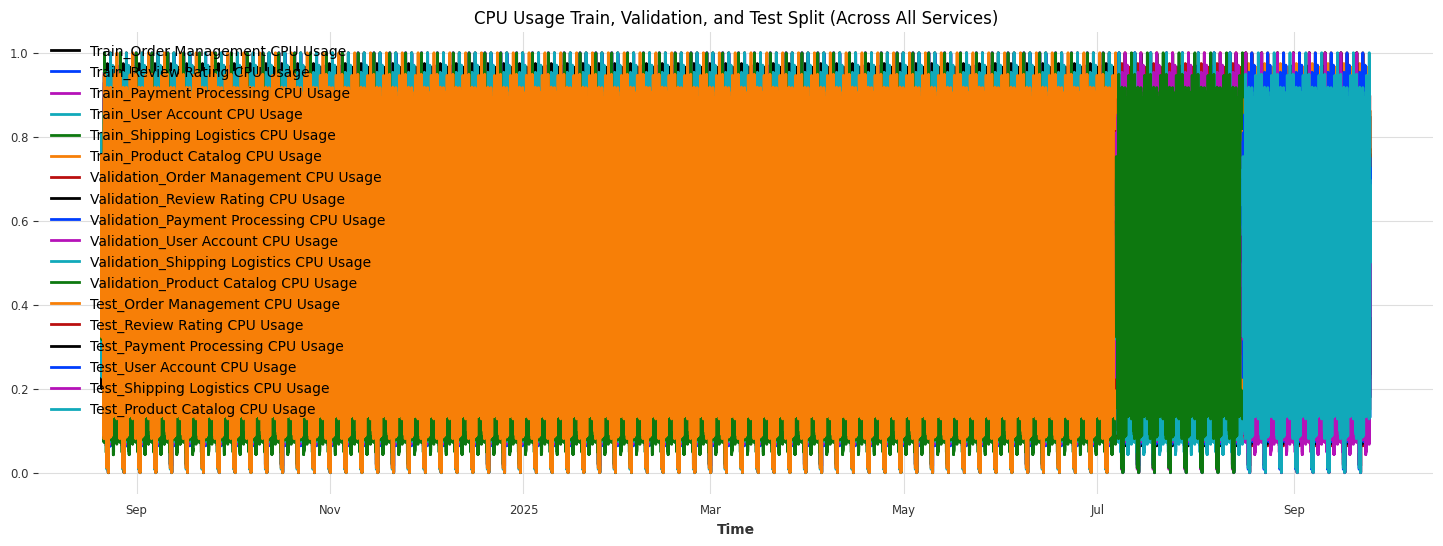

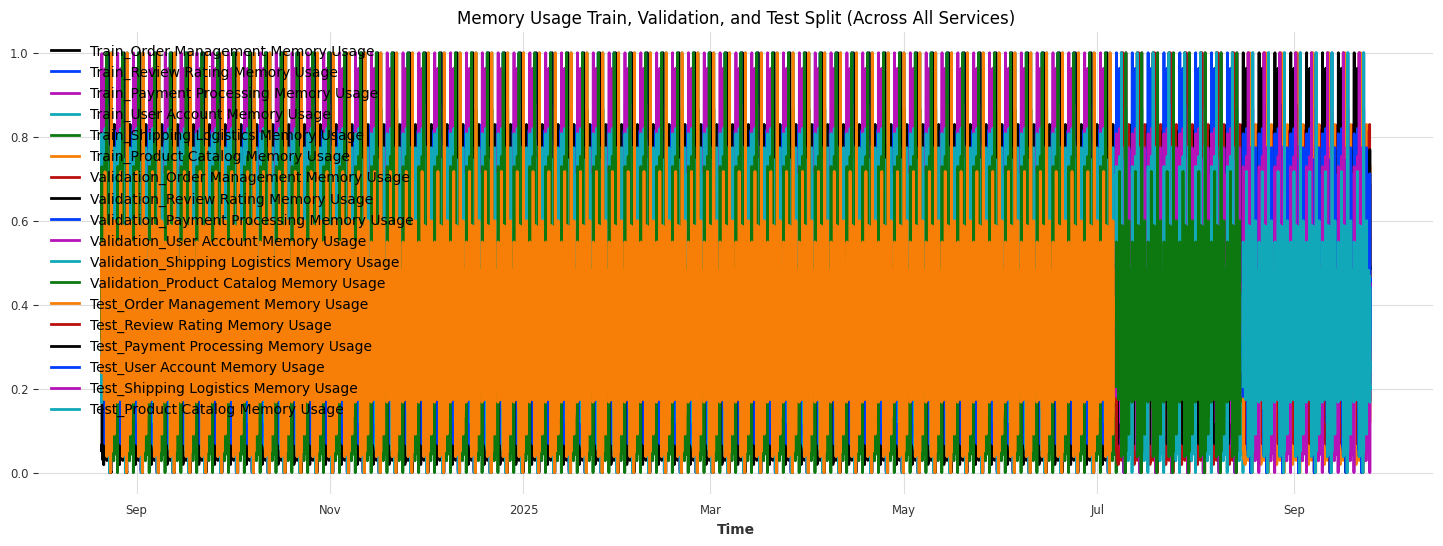

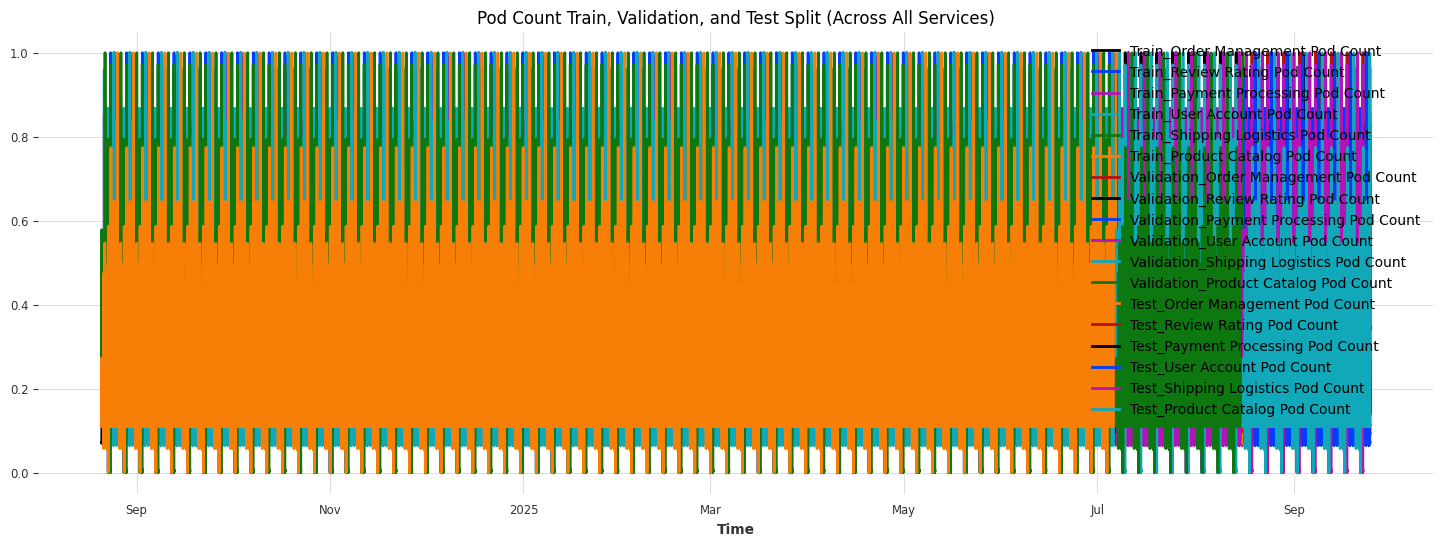

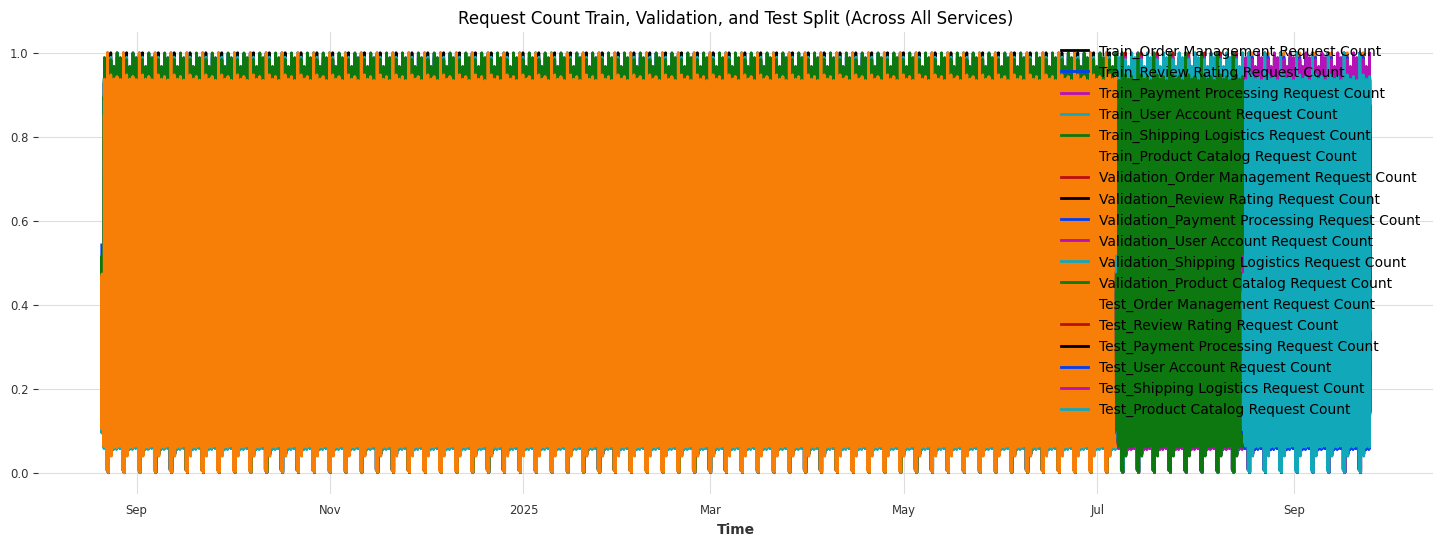

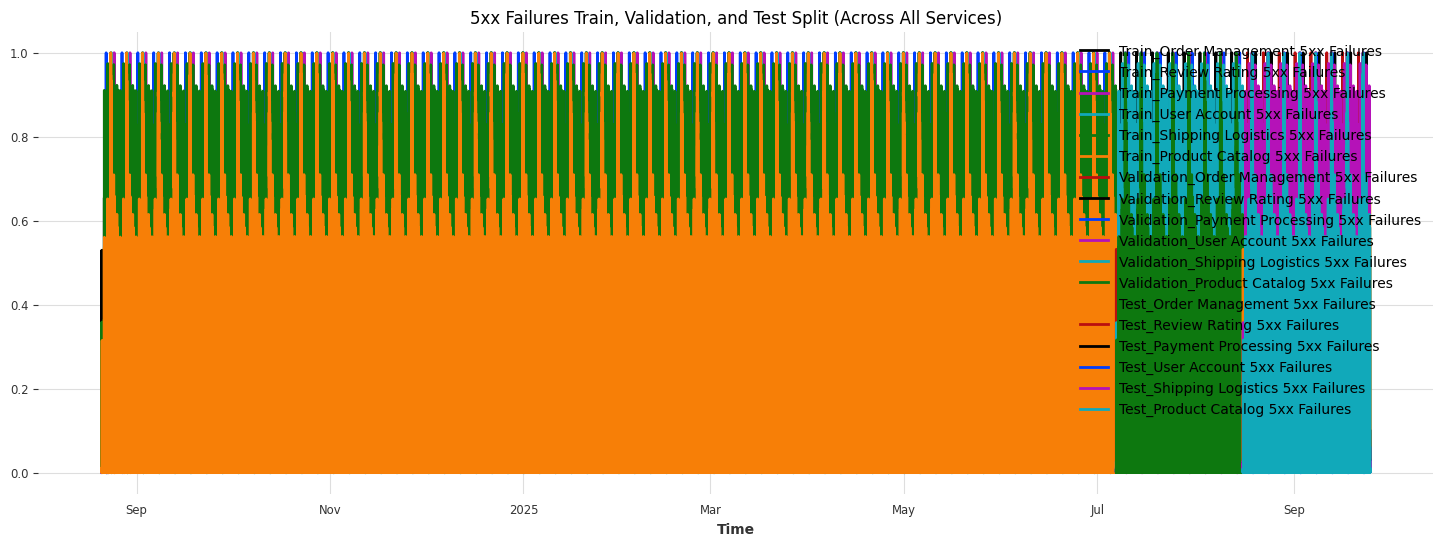

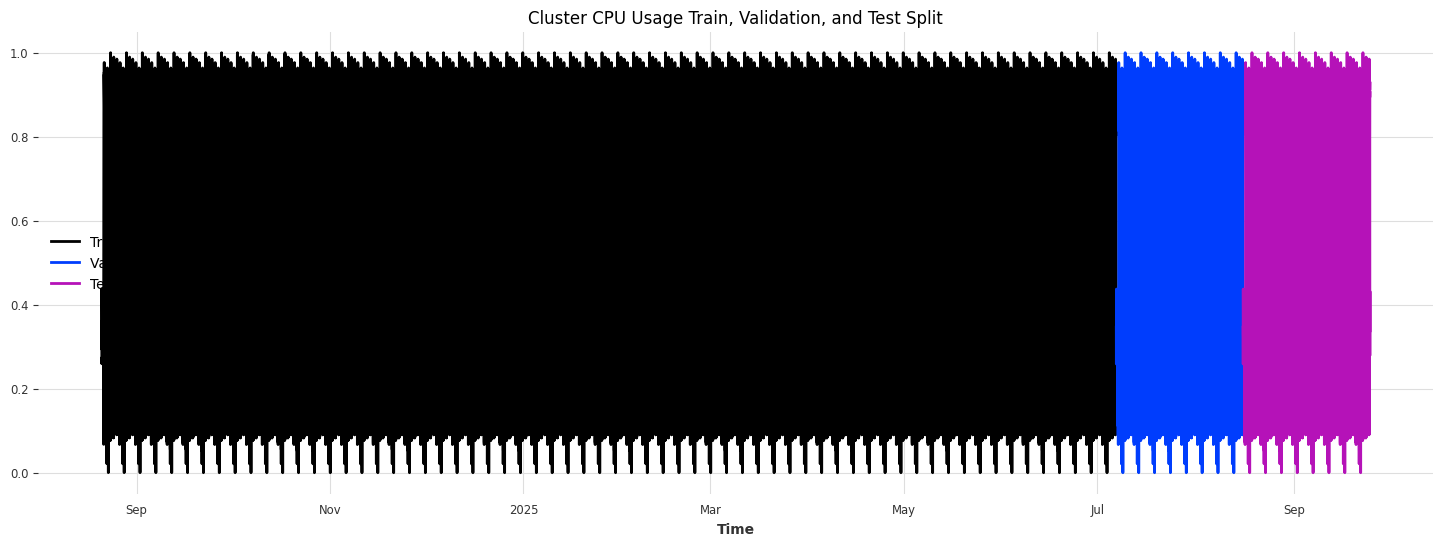

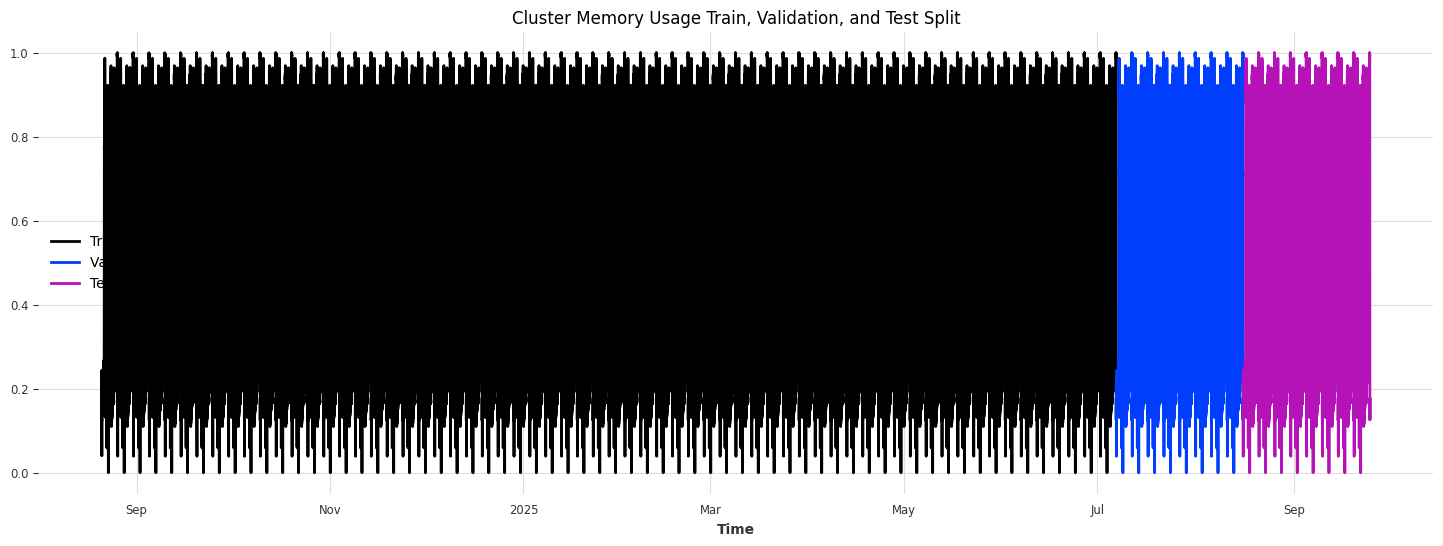

In [5]:
train_size = 0.8  # 80% of the data for training
val_size = 0.1   # 10% of the data for validation
test_size = 0.1  # 10% of the data for testing

### 1. Service-Level Features (Specific to each Services)

# 1. CPU Usage (Across all services)
series_order_cpu = TimeSeries.from_dataframe(order_smoothed, 'Time', 'Order Management CPU Usage')
series_review_cpu = TimeSeries.from_dataframe(reviews_smoothed, 'Time', 'Review Rating CPU Usage')
series_payment_cpu = TimeSeries.from_dataframe(payment_smoothed, 'Time', 'Payment Processing CPU Usage')
series_user_cpu = TimeSeries.from_dataframe(user_smoothed, 'Time', 'User Account CPU Usage')
series_shipping_cpu = TimeSeries.from_dataframe(shipping_smoothed, 'Time', 'Shipping Logistics CPU Usage')
series_product_cpu = TimeSeries.from_dataframe(product_smoothed, 'Time', 'Product Catalog CPU Usage')

# Stack all services' CPU usage into one feature-centric time series
series_cpu_all_services = (
    series_order_cpu.stack(series_review_cpu)
    .stack(series_payment_cpu)
    .stack(series_user_cpu)
    .stack(series_shipping_cpu)
    .stack(series_product_cpu)
)

# Normalize/Scale the data for CPU usage
scaler_cpu = Scaler(MinMaxScaler())
series_cpu_all_services_scaled = scaler_cpu.fit_transform(series_cpu_all_services)

# Train/Test/Validation Split for CPU usage
train_val_cutoff_cpu = int(train_size * len(series_cpu_all_services_scaled))
val_test_cutoff_cpu = int((train_size + val_size) * len(series_cpu_all_services_scaled))

train_series_cpu = series_cpu_all_services_scaled[:train_val_cutoff_cpu]
val_series_cpu = series_cpu_all_services_scaled[train_val_cutoff_cpu:val_test_cutoff_cpu]
test_series_cpu = series_cpu_all_services_scaled[val_test_cutoff_cpu:]

plt.figure(figsize=(18, 6))
train_series_cpu.plot(label='Train')
val_series_cpu.plot(label='Validation')
test_series_cpu.plot(label='Test')
plt.title("CPU Usage Train, Validation, and Test Split (Across All Services)")
plt.legend()
plt.show()


# 2. Memory Usage (Across all services)
series_order_memory = TimeSeries.from_dataframe(order_smoothed, 'Time', 'Order Management Memory Usage')
series_review_memory = TimeSeries.from_dataframe(reviews_smoothed, 'Time', 'Review Rating Memory Usage')
series_payment_memory = TimeSeries.from_dataframe(payment_smoothed, 'Time', 'Payment Processing Memory Usage')
series_user_memory = TimeSeries.from_dataframe(user_smoothed, 'Time', 'User Account Memory Usage')
series_shipping_memory = TimeSeries.from_dataframe(shipping_smoothed, 'Time', 'Shipping Logistics Memory Usage')
series_product_memory = TimeSeries.from_dataframe(product_smoothed, 'Time', 'Product Catalog Memory Usage')

# Stack all services' memory usage into one feature-centric time series
series_memory_all_services = (
    series_order_memory.stack(series_review_memory)
    .stack(series_payment_memory)
    .stack(series_user_memory)
    .stack(series_shipping_memory)
    .stack(series_product_memory)
)

# Normalize/Scale the data for Memory usage
scaler_memory = Scaler(MinMaxScaler())
series_memory_all_services_scaled = scaler_memory.fit_transform(series_memory_all_services)

# Train/Test/Validation Split for Memory usage
train_val_cutoff_memory = int(train_size * len(series_memory_all_services_scaled))
val_test_cutoff_memory = int((train_size + val_size) * len(series_memory_all_services_scaled))

train_series_memory = series_memory_all_services_scaled[:train_val_cutoff_memory]
val_series_memory = series_memory_all_services_scaled[train_val_cutoff_memory:val_test_cutoff_memory]
test_series_memory = series_memory_all_services_scaled[val_test_cutoff_memory:]

plt.figure(figsize=(18, 6))
train_series_memory.plot(label='Train')
val_series_memory.plot(label='Validation')
test_series_memory.plot(label='Test')
plt.title("Memory Usage Train, Validation, and Test Split (Across All Services)")
plt.legend()
plt.show()


# 3. Pod Count (Across all services)
series_order_pod_count = TimeSeries.from_dataframe(order_smoothed, 'Time', 'Order Management Pod Count')
series_review_pod_count = TimeSeries.from_dataframe(reviews_smoothed, 'Time', 'Review Rating Pod Count')
series_payment_pod_count = TimeSeries.from_dataframe(payment_smoothed, 'Time', 'Payment Processing Pod Count')
series_user_pod_count = TimeSeries.from_dataframe(user_smoothed, 'Time', 'User Account Pod Count')
series_shipping_pod_count = TimeSeries.from_dataframe(shipping_smoothed, 'Time', 'Shipping Logistics Pod Count')
series_product_pod_count = TimeSeries.from_dataframe(product_smoothed, 'Time', 'Product Catalog Pod Count')

# Stack all services' pod count into one feature-centric time series
series_pod_count_all_services = (
    series_order_pod_count.stack(series_review_pod_count)
    .stack(series_payment_pod_count)
    .stack(series_user_pod_count)
    .stack(series_shipping_pod_count)
    .stack(series_product_pod_count)
)

# Normalize/Scale the data for Pod Count
scaler_pod_count = Scaler(MinMaxScaler())
series_pod_count_all_services_scaled = scaler_pod_count.fit_transform(series_pod_count_all_services)

# Train/Test/Validation Split for Pod Count
train_val_cutoff_pod_count = int(train_size * len(series_pod_count_all_services_scaled))
val_test_cutoff_pod_count = int((train_size + val_size) * len(series_pod_count_all_services_scaled))

train_series_pod_count = series_pod_count_all_services_scaled[:train_val_cutoff_pod_count]
val_series_pod_count = series_pod_count_all_services_scaled[train_val_cutoff_pod_count:val_test_cutoff_pod_count]
test_series_pod_count = series_pod_count_all_services_scaled[val_test_cutoff_pod_count:]

plt.figure(figsize=(18, 6))
train_series_pod_count.plot(label='Train')
val_series_pod_count.plot(label='Validation')
test_series_pod_count.plot(label='Test')
plt.title("Pod Count Train, Validation, and Test Split (Across All Services)")
plt.legend()
plt.show()


# 4. Request Count (Across all services)
series_order_request_count = TimeSeries.from_dataframe(order_smoothed, 'Time', 'Order Management Request Count')
series_review_request_count = TimeSeries.from_dataframe(reviews_smoothed, 'Time', 'Review Rating Request Count')
series_payment_request_count = TimeSeries.from_dataframe(payment_smoothed, 'Time', 'Payment Processing Request Count')
series_user_request_count = TimeSeries.from_dataframe(user_smoothed, 'Time', 'User Account Request Count')
series_shipping_request_count = TimeSeries.from_dataframe(shipping_smoothed, 'Time', 'Shipping Logistics Request Count')
series_product_request_count = TimeSeries.from_dataframe(product_smoothed, 'Time', 'Product Catalog Request Count')

# Stack all services' request count into one feature-centric time series
series_request_count_all_services = (
    series_order_request_count.stack(series_review_request_count)
    .stack(series_payment_request_count)
    .stack(series_user_request_count)
    .stack(series_shipping_request_count)
    .stack(series_product_request_count)
)

# Normalize/Scale the data for Request Count
scaler_request_count = Scaler(MinMaxScaler())
series_request_count_all_services_scaled = scaler_request_count.fit_transform(series_request_count_all_services)

# Train/Test/Validation Split for Request Count
train_val_cutoff_request_count = int(train_size * len(series_request_count_all_services_scaled))
val_test_cutoff_request_count = int((train_size + val_size) * len(series_request_count_all_services_scaled))

train_series_request_count = series_request_count_all_services_scaled[:train_val_cutoff_request_count]
val_series_request_count = series_request_count_all_services_scaled[train_val_cutoff_request_count:val_test_cutoff_request_count]
test_series_request_count = series_request_count_all_services_scaled[val_test_cutoff_request_count:]

plt.figure(figsize=(18, 6))
train_series_request_count.plot(label='Train')
val_series_request_count.plot(label='Validation')
test_series_request_count.plot(label='Test')
plt.title("Request Count Train, Validation, and Test Split (Across All Services)")
plt.legend()
plt.show()


# 5. 5xx Failures (Across all services)
series_order_5xx_failures = TimeSeries.from_dataframe(order_smoothed, 'Time', 'Order Management 5xx Failures')
series_review_5xx_failures = TimeSeries.from_dataframe(reviews_smoothed, 'Time', 'Review Rating 5xx Failures')
series_payment_5xx_failures = TimeSeries.from_dataframe(payment_smoothed, 'Time', 'Payment Processing 5xx Failures')
series_user_5xx_failures = TimeSeries.from_dataframe(user_smoothed, 'Time', 'User Account 5xx Failures')
series_shipping_5xx_failures = TimeSeries.from_dataframe(shipping_smoothed, 'Time', 'Shipping Logistics 5xx Failures')
series_product_5xx_failures = TimeSeries.from_dataframe(product_smoothed, 'Time', 'Product Catalog 5xx Failures')

# Stack all services' 5xx failures into one feature-centric time series
series_5xx_failures_all_services = (
    series_order_5xx_failures.stack(series_review_5xx_failures)
    .stack(series_payment_5xx_failures)
    .stack(series_user_5xx_failures)
    .stack(series_shipping_5xx_failures)
    .stack(series_product_5xx_failures)
)

# Normalize/Scale the data for 5xx Failures
scaler_5xx_failures = Scaler(MinMaxScaler())
series_5xx_failures_all_services_scaled = scaler_5xx_failures.fit_transform(series_5xx_failures_all_services)

# Train/Test/Validation Split for 5xx Failures
train_val_cutoff_5xx_failures = int(train_size * len(series_5xx_failures_all_services_scaled))
val_test_cutoff_5xx_failures = int((train_size + val_size) * len(series_5xx_failures_all_services_scaled))

train_series_5xx_failures = series_5xx_failures_all_services_scaled[:train_val_cutoff_5xx_failures]
val_series_5xx_failures = series_5xx_failures_all_services_scaled[train_val_cutoff_5xx_failures:val_test_cutoff_5xx_failures]
test_series_5xx_failures = series_5xx_failures_all_services_scaled[val_test_cutoff_5xx_failures:]

plt.figure(figsize=(18, 6))
train_series_5xx_failures.plot(label='Train')
val_series_5xx_failures.plot(label='Validation')
test_series_5xx_failures.plot(label='Test')
plt.title("5xx Failures Train, Validation, and Test Split (Across All Services)")
plt.legend()
plt.show()


### 2. Cluster-Level Features (Common to All Services)

# Fetch Cluster CPU and Memory from Order Management data (since it's common across all services)
series_cluster_cpu = TimeSeries.from_dataframe(order_smoothed, 'Time', 'Cluster CPU')
series_cluster_memory = TimeSeries.from_dataframe(order_smoothed, 'Time', 'Cluster Memory')

# Normalize/Scale the data for Cluster CPU and Memory
scaler_cluster_cpu = Scaler(MinMaxScaler())
scaler_cluster_memory = Scaler(MinMaxScaler())

series_cluster_cpu_scaled = scaler_cluster_cpu.fit_transform(series_cluster_cpu)
series_cluster_memory_scaled = scaler_cluster_memory.fit_transform(series_cluster_memory)

# Train/Test/Validation Split for Cluster CPU
train_val_cutoff_cluster_cpu = int(train_size * len(series_cluster_cpu_scaled))
val_test_cutoff_cluster_cpu = int((train_size + val_size) * len(series_cluster_cpu_scaled))

train_series_cluster_cpu = series_cluster_cpu_scaled[:train_val_cutoff_cluster_cpu]
val_series_cluster_cpu = series_cluster_cpu_scaled[train_val_cutoff_cluster_cpu:val_test_cutoff_cluster_cpu]
test_series_cluster_cpu = series_cluster_cpu_scaled[val_test_cutoff_cluster_cpu:]

# Train/Test/Validation Split for Cluster Memory
train_val_cutoff_cluster_memory = int(train_size * len(series_cluster_memory_scaled))
val_test_cutoff_cluster_memory = int((train_size + val_size) * len(series_cluster_memory_scaled))

train_series_cluster_memory = series_cluster_memory_scaled[:train_val_cutoff_cluster_memory]
val_series_cluster_memory = series_cluster_memory_scaled[train_val_cutoff_cluster_memory:val_test_cutoff_cluster_memory]
test_series_cluster_memory = series_cluster_memory_scaled[val_test_cutoff_cluster_memory:]

# Plot Cluster CPU and Memory Splits
plt.figure(figsize=(18, 6))
train_series_cluster_cpu.plot(label='Train (Cluster CPU)')
val_series_cluster_cpu.plot(label='Validation (Cluster CPU)')
test_series_cluster_cpu.plot(label='Test (Cluster CPU)')
plt.title("Cluster CPU Usage Train, Validation, and Test Split")
plt.legend()
plt.show()

plt.figure(figsize=(18, 6))
train_series_cluster_memory.plot(label='Train (Cluster Memory)')
val_series_cluster_memory.plot(label='Validation (Cluster Memory)')
test_series_cluster_memory.plot(label='Test (Cluster Memory)')
plt.title("Cluster Memory Usage Train, Validation, and Test Split")
plt.legend()
plt.show()


In [14]:
import os
import torch
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from darts.models import NHiTSModel, TiDEModel
from darts.utils.likelihood_models import GaussianLikelihood
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pytorch_lightning as pl

# Define model arguments for the feature-centric approach
nhits_model_args = {
    "input_chunk_length": 2880,  # Past 24 hours time steps as input
    "output_chunk_length": 480,  # Predict the next 8 hours time steps
    "n_epochs": 30,
    "random_state": 42, 
    "num_stacks": 10, # previously 7
    "num_layers": 6, # previously 4
    "likelihood": GaussianLikelihood(),  
    "batch_size": 128, # previously 64
    "lr_scheduler_cls": torch.optim.lr_scheduler.ReduceLROnPlateau,
    "lr_scheduler_kwargs": {"factor": 0.5, "patience": 5},
    "save_checkpoints": True,
    "force_reset": True,
    "dropout": 0.25, # previously 0.2
    "optimizer_kwargs": {"lr": 1e-3}  # Define your learning rate here
}

# # Define model arguments for the feature-centric approach
# tide_model_args = {
#     "input_chunk_length": 1440,  # Past 24 hours time steps as input
#     "output_chunk_length": 480,  # Predict the next 8 hours time steps
#     "n_epochs": 30,              # Number of training epochs
#     "random_state": 42,           # For reproducibility
#     "likelihood": GaussianLikelihood(),  # Likelihood model for probabilistic forecasts
#     "batch_size": 128,
#     "lr_scheduler_cls": torch.optim.lr_scheduler.ExponentialLR,
#     "lr_scheduler_kwargs": {"gamma": 0.999},
#     "save_checkpoints": True,
#     "force_reset": True,
#     "dropout": 0.20,
#     "num_encoder_layers": 4,
#     "num_decoder_layers": 4,
#     "optimizer_kwargs": {"lr": 1e-3},  # Define your learning rate here
#     "use_reversible_instance_norm": False,
# }


# Early stopping configuration
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 3,
    "mode": "min",
    "strict": True,
    "verbose": True,
}

# Define log directory
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)

# Create a TensorBoard logger
logger = TensorBoardLogger(log_dir, name="feature_centric_all_models")

# Trainer configuration
pl_trainer_kwargs = {
    "max_epochs": 30,
    "logger": logger
}

# Directory where models will be saved
model_dir = os.path.expanduser("~/Documents/models_new/")
os.makedirs(model_dir, exist_ok=True)  # Create the directory if it doesn't exist


In [15]:
# Define a function to train the model
def train_model(train_series, val_series, model_name):
    model = NHiTSModel(model_name=model_name, **nhits_model_args)
    pl_trainer = pl.Trainer(**pl_trainer_kwargs)

    pl_trainer_kwargs["callbacks"] = [
        EarlyStopping(
            **early_stopping_args,
        )
    ]
    # Fit the model
    model.fit(
        series=train_series,
        val_series=val_series,
        verbose=True,
    )

    # Load the model from its best state/checkpoint
    model = model.load_from_checkpoint(model_name=model_name, best=True)

    # Save the model
    model.save(os.path.join(model_dir, f"{model_name}.pt"))

    return model

# Define all feature series
train_series_dict = {
    "5xx_failures": (train_series_5xx_failures, val_series_5xx_failures),
    "request_count": (train_series_request_count, val_series_request_count),
    "memory": (train_series_memory, val_series_memory),
    "cpu": (train_series_cpu, val_series_cpu),
    "pod_count": (train_series_pod_count, val_series_pod_count)
}

# Define and train univariate models for cluster CPU and memory
univariate_series_dict = {
    "cluster_cpu": (train_series_cluster_cpu, val_series_cluster_cpu),
    "cluster_memory": (train_series_cluster_memory, val_series_cluster_memory)
}

In [ ]:
for feature_name, (train_series, val_series) in univariate_series_dict.items():
    # Train the univariate model
    model_name = f"{feature_name}_model"
    model = train_model(train_series, val_series, model_name)

# Loop through each feature and train the models
for feature_name, (train_series, val_series) in train_series_dict.items():
    # Train the model
    model_name = f"{feature_name}_model"
    model = train_model(train_series, val_series, model_name)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 21.2 M | train
-------------------------------------------------------------
19.7 M    Trainable params
1.5 M     Non-trainable params
21.2 M    Total params
84.726    Total estimated model params size (MB)
206       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

Predicting: |                                                                                                 …

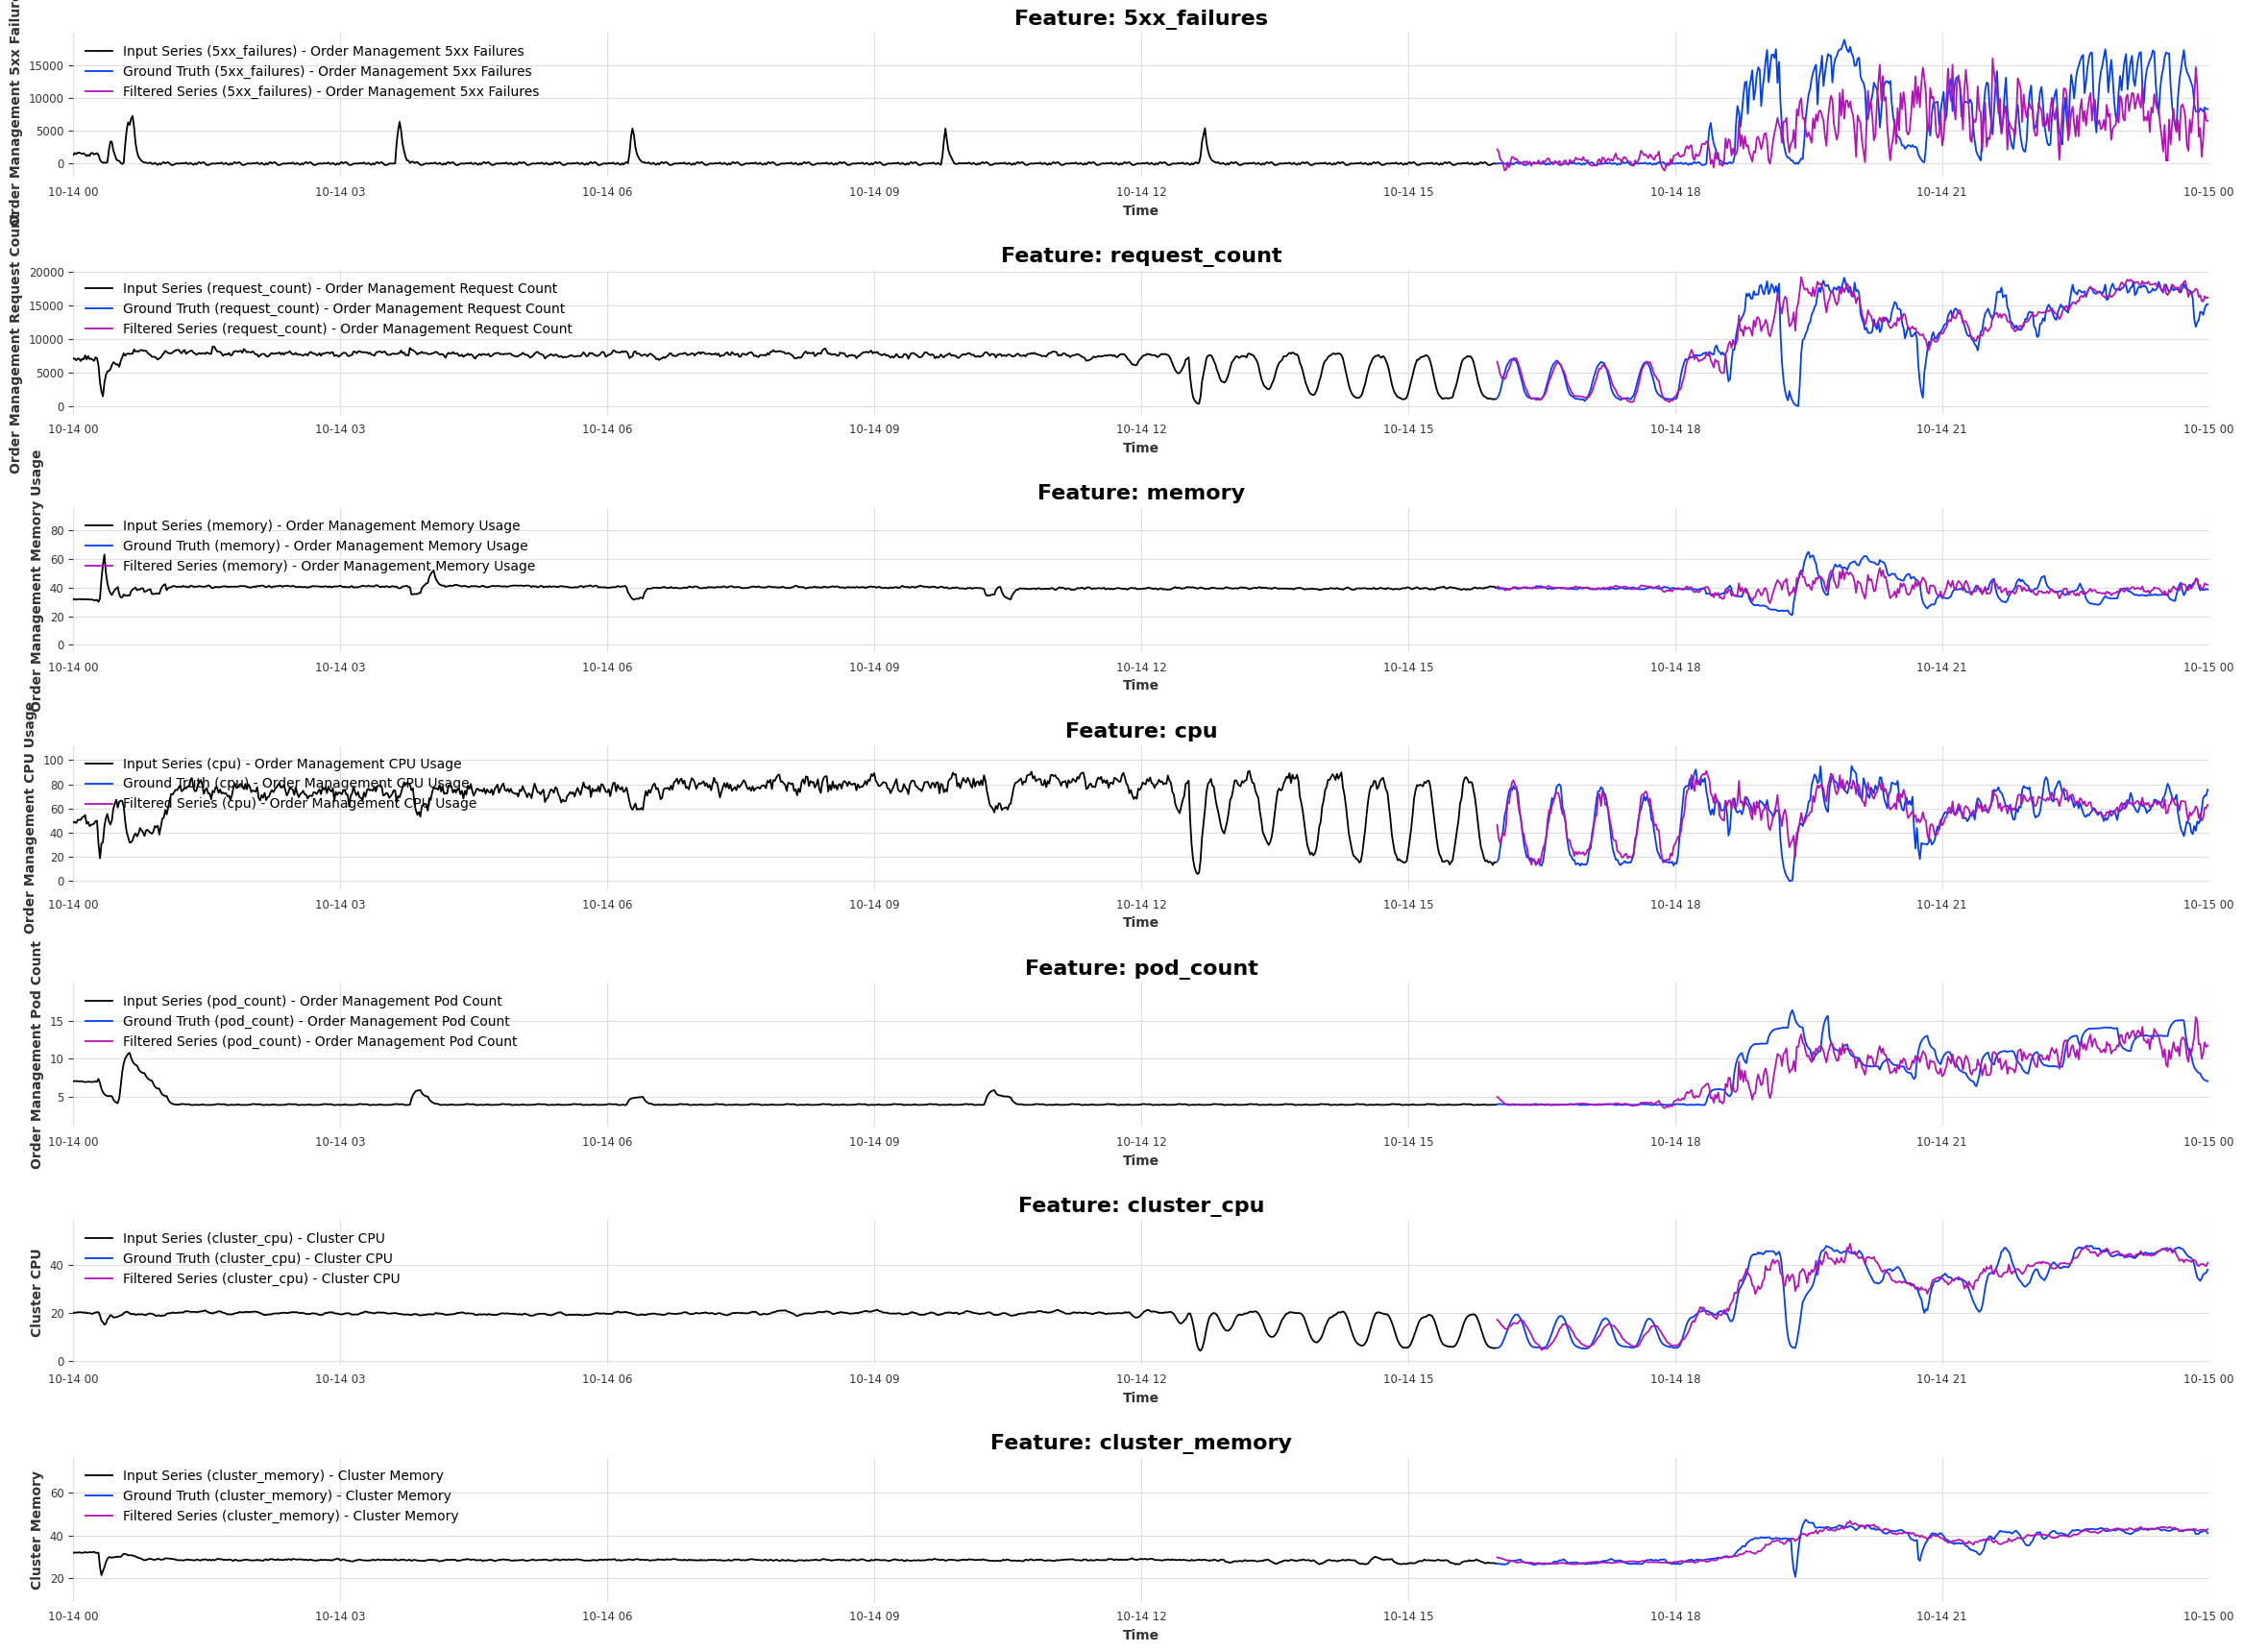

In [10]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from darts.models import NHiTSModel
import numpy as np
import pandas as pd
from datetime import datetime
from pykalman import KalmanFilter

# Directory where the models are saved
model_dir = os.path.expanduser("~/Documents/models_new/")

# Prediction steps
pred_steps = 480

# Define the prediction date range
start_date = datetime(2025, 10, 14)
end_date = datetime(2025, 10, 15)

# Prepare a dictionary for models based on your feature-centric approach
models_dict = {
    "5xx_failures": NHiTSModel.load(os.path.join(model_dir, "5xx_failures_model.pt")),
    "request_count": NHiTSModel.load(os.path.join(model_dir, "request_count_model.pt")),
    "memory": NHiTSModel.load(os.path.join(model_dir, "memory_model.pt")),
    "cpu": NHiTSModel.load(os.path.join(model_dir, "cpu_model.pt")),
    "pod_count": NHiTSModel.load(os.path.join(model_dir, "pod_count_model.pt")),
    "cluster_cpu": NHiTSModel.load(os.path.join(model_dir, "cluster_cpu_model.pt")),
    "cluster_memory": NHiTSModel.load(os.path.join(model_dir, "cluster_memory_model.pt")),
}

# Prepare a dictionary for input and ground truth series
test_series_dict = {
    "5xx_failures": test_series_5xx_failures,
    "request_count": test_series_request_count,
    "memory": test_series_memory,
    "cpu": test_series_cpu,
    "pod_count": test_series_pod_count,
    "cluster_cpu": test_series_cluster_cpu,
    "cluster_memory": test_series_cluster_memory,
}

# Explicit mapping of feature names to their corresponding column names in your data
column_name_mapping = {
    "5xx_failures": [
        "Order Management 5xx Failures",
        # "Review Rating 5xx Failures",
        # "Payment Processing 5xx Failures",
        # "User Account 5xx Failures",
        # "Shipping Logistics 5xx Failures",
        # "Product Catalog 5xx Failures"
    ],
    "request_count": [
        "Order Management Request Count",
        # "Review Rating Request Count",
        # "Payment Processing Request Count",
        # "User Account Request Count",
        # "Shipping Logistics Request Count",
        # "Product Catalog Request Count"
    ],
    "memory": [
        "Order Management Memory Usage",
        # "Review Rating Memory Usage",
        # "Payment Processing Memory Usage",
        # "User Account Memory Usage",
        # "Shipping Logistics Memory Usage",
        # "Product Catalog Memory Usage"
    ],
    "cpu": [
        "Order Management CPU Usage",
        # "Review Rating CPU Usage",
        # "Payment Processing CPU Usage",
        # "User Account CPU Usage",
        # "Shipping Logistics CPU Usage",
        # "Product Catalog CPU Usage"
    ],
    "pod_count": [
        "Order Management Pod Count",
        # "Review Rating Pod Count",
        # "Payment Processing Pod Count",
        # "User Account Pod Count",
        # "Shipping Logistics Pod Count",
        # "Product Catalog Pod Count"
    ],
    "cluster_cpu": [
        "Cluster CPU"
    ],
    "cluster_memory": [
        "Cluster Memory"
    ]
}

# Create a 7x1 subplot to visualize the series
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(24, 18))
fig.tight_layout(pad=5.0)

# Define a dictionary for scalers
scalers_dict = {
    "5xx_failures": scaler_5xx_failures,
    "request_count": scaler_request_count,
    "memory": scaler_memory,
    "cpu": scaler_cpu,
    "pod_count": scaler_pod_count,
    "cluster_cpu": scaler_cluster_cpu,
    "cluster_memory": scaler_cluster_memory,
}

kf_params = {
    "5xx_failures": {"initial_state_covariance": 0.3, "transition_covariance": 0.5, "observation_covariance": 0.2},
    "request_count": {"initial_state_covariance": 0.2, "transition_covariance": 0.1, "observation_covariance": 0.5},
    "memory": {"initial_state_covariance": 0.3, "transition_covariance": 0.3, "observation_covariance": 0.2},
    "cpu": {"initial_state_covariance": 0.2, "transition_covariance": 0.3, "observation_covariance": 0.5},
    "pod_count": {"initial_state_covariance": 0.3, "transition_covariance": 0.3, "observation_covariance": 0.3},
    "cluster_cpu": {"initial_state_covariance": 0.2, "transition_covariance": 0.1, "observation_covariance": 0.5},
    "cluster_memory": {"initial_state_covariance": 0.2, "transition_covariance": 0.1, "observation_covariance": 0.5},
}


# Create a dictionary to store separate DataFrames for each service
service_dataframes = {}

# Loop through each feature and perform predictions
for idx, (feature_name, model) in enumerate(models_dict.items()):
    # Prepare the input and ground truth series
    pred_input = test_series_dict[feature_name][:-pred_steps]  # Input data for prediction
    ground_truth = test_series_dict[feature_name][-pred_steps:]  # Actual future data

    # Get the appropriate scaler for this feature
    scaler = scalers_dict[feature_name]
    
    # Predict the next `pred_steps` points
    pred_series = model.predict(n=pred_steps, series=pred_input)

    # Inverse transform the series to get actual values
    input_series = scaler.inverse_transform(pred_input).pd_dataframe()
    ground_series = scaler.inverse_transform(ground_truth).pd_dataframe()
    predicted_series = scaler.inverse_transform(pred_series).pd_dataframe()

    params = kf_params[feature_name]
    
    kf = KalmanFilter(
        initial_state_mean=predicted_series.mean(axis=0).values,
        n_dim_state=predicted_series.shape[1],
        n_dim_obs=predicted_series.shape[1],
        initial_state_covariance=np.eye(predicted_series.shape[1]) * params["initial_state_covariance"],
        transition_matrices=np.eye(predicted_series.shape[1]),
        observation_matrices=np.eye(predicted_series.shape[1]),
        transition_covariance=np.eye(predicted_series.shape[1]) * params["transition_covariance"],
        observation_covariance=np.eye(predicted_series.shape[1]) * params["observation_covariance"]
    )

    kf = kf.em(predicted_series.values, n_iter=10)
    (filtered_state_means, _) = kf.filter(predicted_series.values)

    # Convert filtered results back to DataFrame for easier plotting
    filtered_series = pd.DataFrame(filtered_state_means, index=predicted_series.index, columns=predicted_series.columns)

    # Loop through all columns for this feature and plot each one
    for column in column_name_mapping[feature_name]:
        # Plotting the series and include the model name in the label
        sns.lineplot(ax=axes[idx], x=input_series.index, y=input_series[column], label=f'Input Series ({feature_name}) - {column}')
        sns.lineplot(ax=axes[idx], x=ground_series.index, y=ground_series[column], label=f'Ground Truth ({feature_name}) - {column}')
        # sns.lineplot(ax=axes[idx], x=predicted_series.index, y=predicted_series[column], label=f'Predicted Series ({feature_name}) - {column}')
        sns.lineplot(ax=axes[idx], x=filtered_series.index, y=filtered_series[column], label=f'Filtered Series ({feature_name}) - {column}')

    axes[idx].set_title(f"Feature: {feature_name}", fontsize=16, fontweight='bold')
    axes[idx].legend(loc='upper left')
    axes[idx].set_xlim(left=start_date, right=end_date)

    for column in column_name_mapping[feature_name]:
        service_name = column.split()[0]  # Get service name from the column name
        if service_name not in service_dataframes:
            service_dataframes[service_name] = pd.DataFrame(index=predicted_series.index)

        # Store predictions and ground truth
        service_dataframes[service_name][f"{column}"] = filtered_series[column]
        # service_dataframes[service_name][f"{column} Ground Truth"] = ground_series[column]


# Display the plot
plt.savefig('Final Predictions with Kalman Filter.png')
plt.show()


In [31]:
# Save each service DataFrame to separate CSV files
for service_name, df in service_dataframes.items():
    df.to_csv(f"{service_name}_filtered_predictions.csv")

In [19]:
import shap
import numpy as np
import pandas as pd
from darts import TimeSeries

# Define the prediction function for the NHITS model
def predict_pod_count(data):
    temp_series_df = pd.DataFrame(data, columns=test_series_pod_count.pd_dataframe().columns)
    temp_series = TimeSeries.from_dataframe(temp_series_df)

    # Predict using the NHITS model
    pred_series = nhits_pod_count_model.predict(n=pred_steps, series=temp_series)
    
    # Return predictions as a numpy array and ensure it has the correct shape
    return pred_series.values().reshape(-1, 1)  # Reshape to have a single output per input row

# Convert the TimeSeries object to a DataFrame and subset for SHAP analysis
input_series_subset = test_series_pod_count.pd_dataframe().iloc[:1500]

# Reshape the data for SHAP's KernelExplainer
input_reshaped = input_series_subset.values

# Initialize SHAP's KernelExplainer with the reshaped input
explainer = shap.KernelExplainer(predict_pod_count, input_reshaped)

# Compute SHAP values for a subset of the data
shap_values = explainer.shap_values(input_reshaped[:480])  # Adjust the sample size as needed

# Visualize SHAP values
shap.summary_plot(shap_values, input_reshaped[:480])


Predicting: |                                                                       | 0/? [00:00<?, ?it/s]

ValueError: operands could not be broadcast together with shapes (1,2880) (1500,) 